# Decision Tree and Random Forrest
for the DT we found patterns in the dataset, we chose to partition it by followers count, and for each bucket we used a different decioion tree
The buckets we found using KMEANS and found it having better resaults than logical - hand partitioning

to maximize output - we chose a different strategy for each bucket:


*   original - keep dataset as is
*   capped 95 - remove 5% of outliers
*   capped 99 - remove 1% of outliers
*   log_transform - preforme log on the dataset
*   sqrt_transform - preforem squreRoot on the dataset

on each bucket we trained we chose the best strategy by max R^2 for each

Eventualy we choose tree depth of **15** after checking manually the results for the depths of 3, 5, 10, 15, 20., giving 15 the best results





In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
Data = pd.read_csv("/content/toxicity_output_combined.csv")

### Visualization:

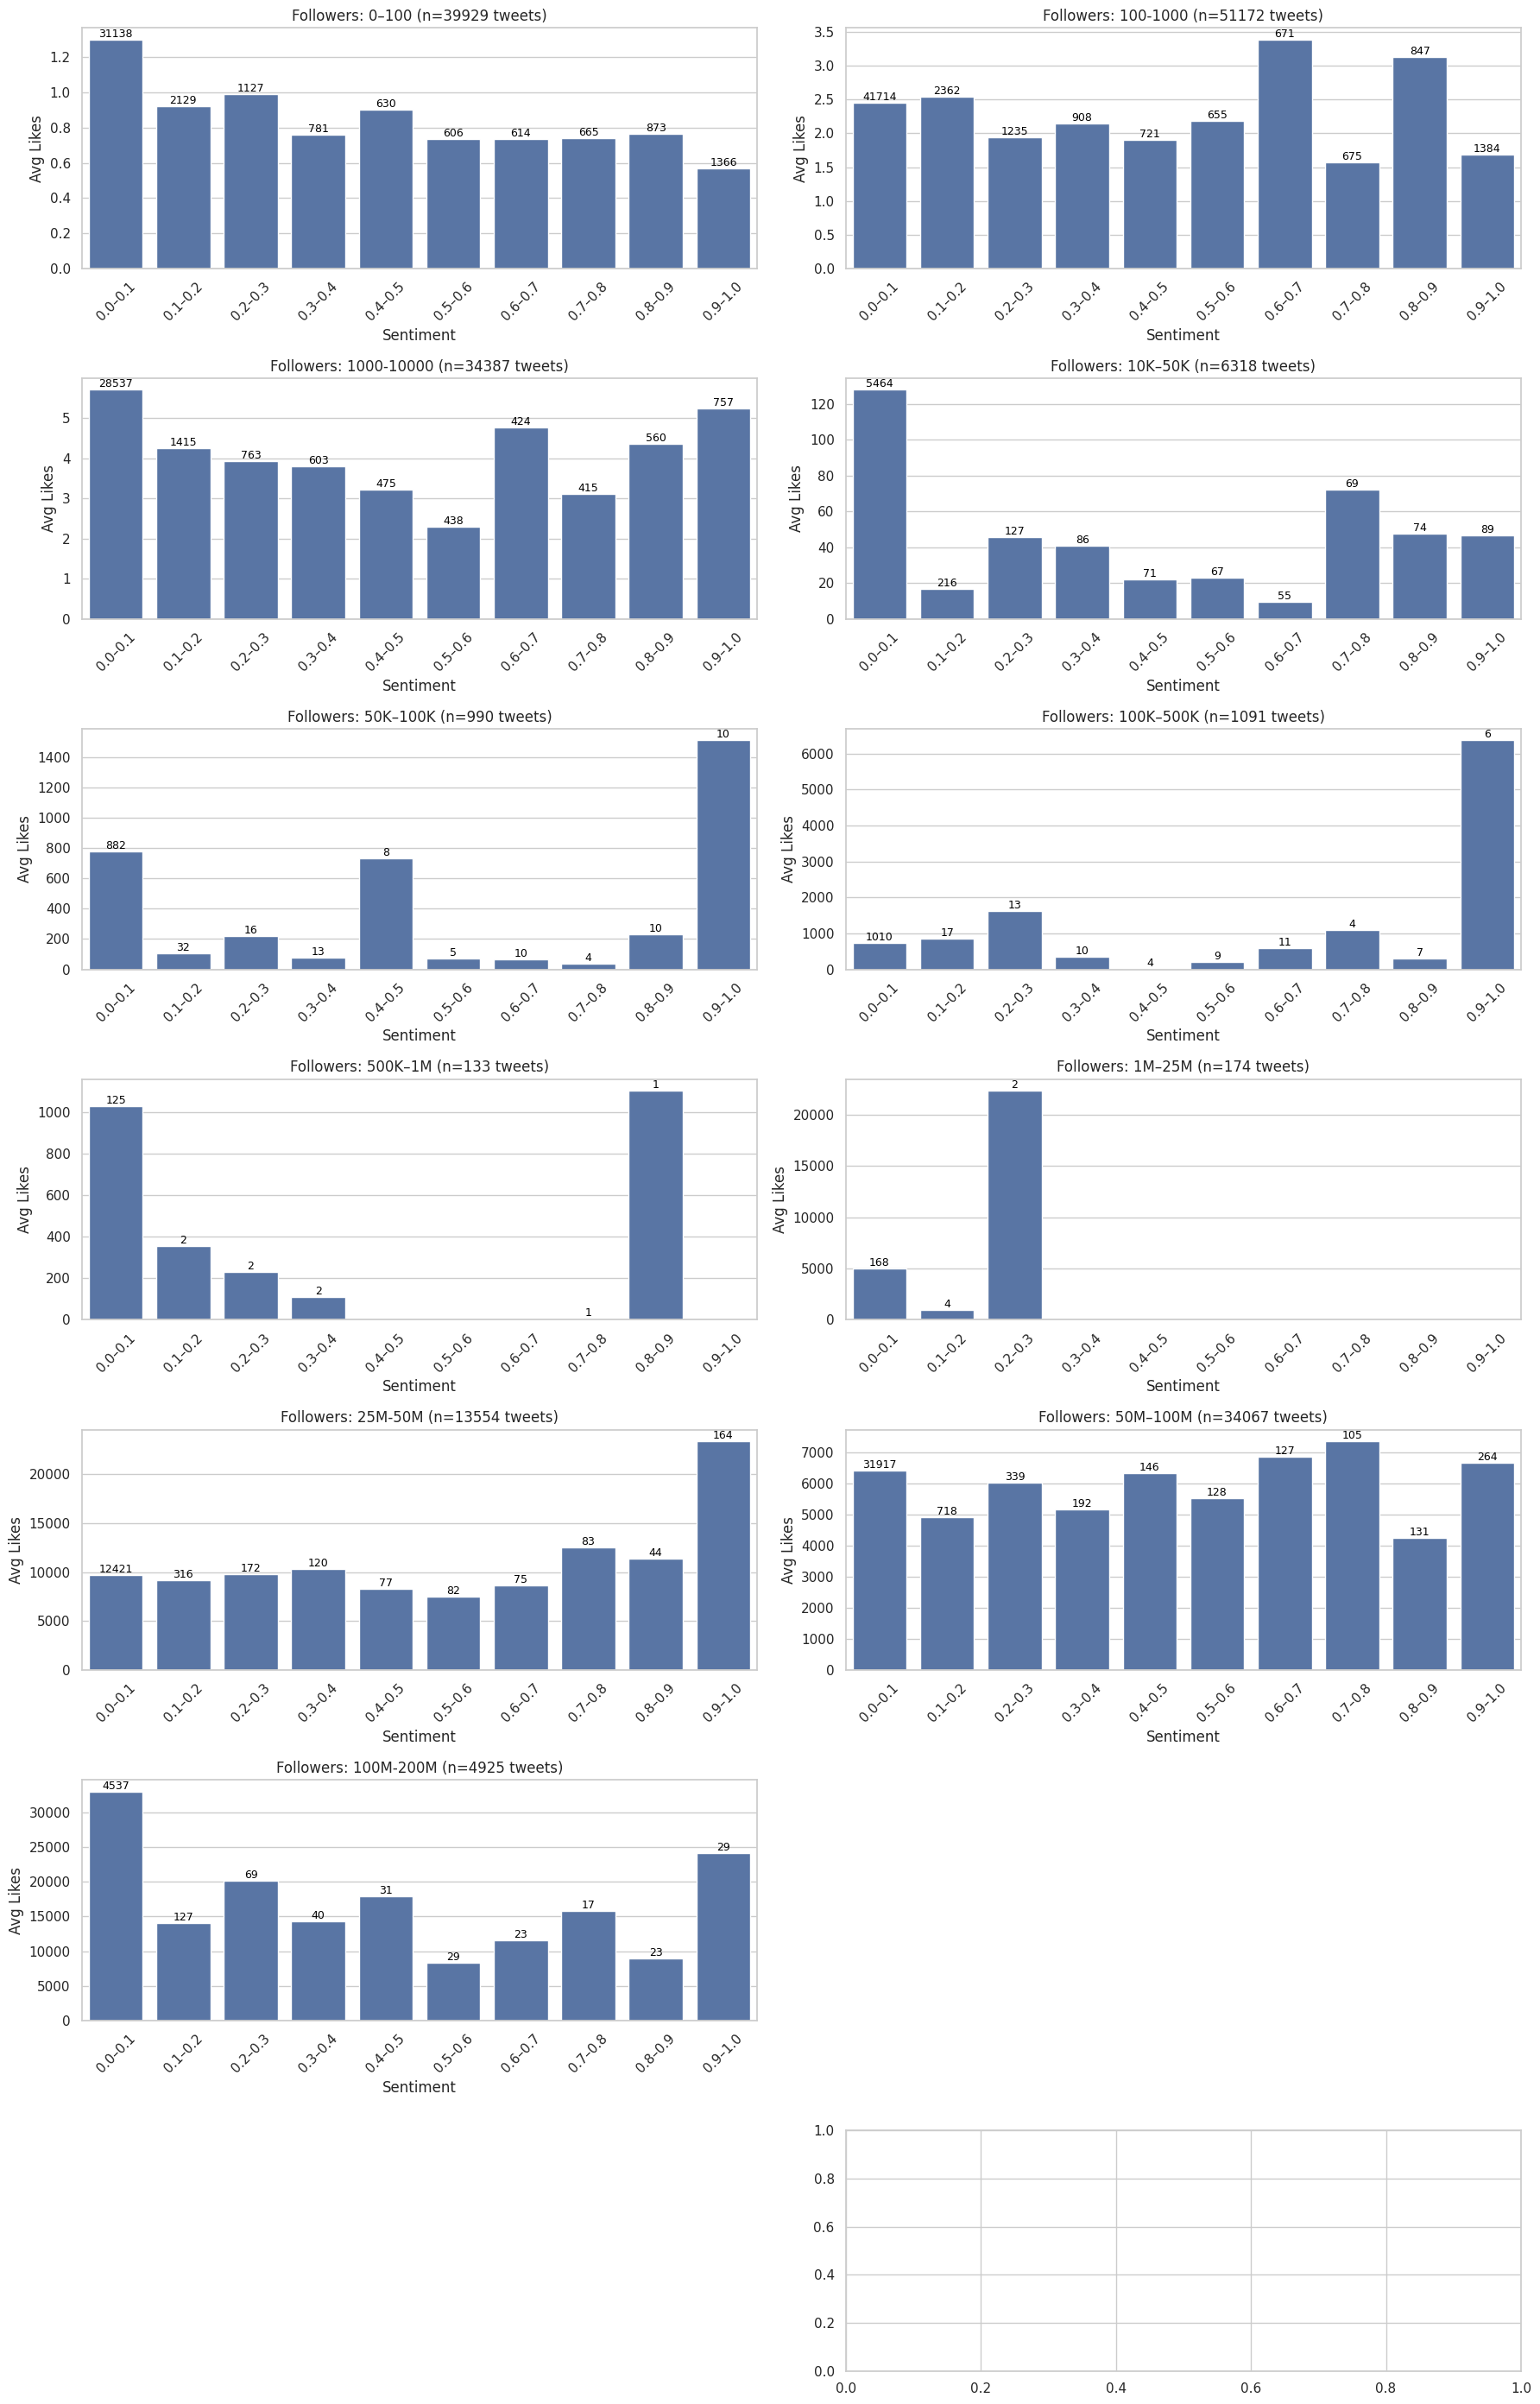

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df=Data.copy()
# Define follower groups
bins = [0,100,1000, 10000, 50000, 100000, 500000, 1000000,25000000, 50000000, 100000000,200000000,300000000, np.inf]
labels = [
    '0–100','100-1000','1000-10000', '10K–50K', '50K–100K',
    '100K–500K', '500K–1M', '1M–25M','25M-50M', '50M–100M', '100M-200M','200M-300M','300M+'
]

df['follower_group'] = pd.cut(df['followers_count'], bins=bins, labels=labels, right=False)

sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(18, 28))
axes = axes.flatten()

for i, group in enumerate(labels):
    ax = axes[i]
    subset = df[df['follower_group'] == group].copy()
    tweet_count = len(subset)

    if not subset.empty:
        sentiment_bins = pd.cut(
            subset['sentiment'],
            bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            labels=[
                '0.0–0.1', '0.1–0.2', '0.2–0.3', '0.3–0.4', '0.4–0.5',
                '0.5–0.6', '0.6–0.7', '0.7–0.8', '0.8–0.9', '0.9–1.0'
            ],
            include_lowest=True,
            right=False)

        subset['sentiment_bin'] = sentiment_bins

        # Compute average likes and count of tweets per sentiment bin
        sentiment_stats = subset.groupby('sentiment_bin', observed=False).agg(
            avg_likes=('number_of_likes', 'mean'),
            count=('number_of_likes', 'count')
        ).reset_index()

        sns.barplot(
            data=sentiment_stats,
            x='sentiment_bin',
            y='avg_likes',
            ax=ax
        )

        # Annotate each bar with the tweet count
        for index, row in sentiment_stats.iterrows():
            ax.text(index, row['avg_likes'], f"{row['count']}", ha='center', va='bottom', fontsize=9, color='black')

        ax.set_title(f'Followers: {group} (n={tweet_count} tweets)')
        ax.set_xlabel('Sentiment')
        ax.set_ylabel('Avg Likes')
        ax.tick_params(axis='x', rotation=45)
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()




# **MODEL Iterations**
Lets first try to find how to partiotion the followrs group using KMEANS

Creating follower-based groups for model routing...
Dataset shape: (186740, 5)
Follower count range: 0 - 130,601,913

Available grouping methods:
  quantile: Equal data distribution in each group
  log: Log-spaced ranges (good for wide follower ranges)
  custom: Custom ranges you define
  kmeans: K-means clustering on follower count

Data distribution analysis:
Min followers: 0
Max followers: 130,601,913
Median followers: 1,113.0
Mean followers: 18,246,559

Follower count percentiles:
  10th percentile: 24
  25th percentile: 140
  50th percentile: 1,113
  75th percentile: 43,000,000
  90th percentile: 70,000,000
  95th percentile: 86,000,000
  99th percentile: 100,000,000
  99.9th percentile: 100,000,000

Using LOG method with 8 groups for better distribution...
Creating 8 follower groups from 185074 valid tweets
Follower count range: 1 - 130,601,913

Also trying CUSTOM ranges that make business sense...
Creating 10 follower groups from 185074 valid tweets
Follower count range: 1 - 130

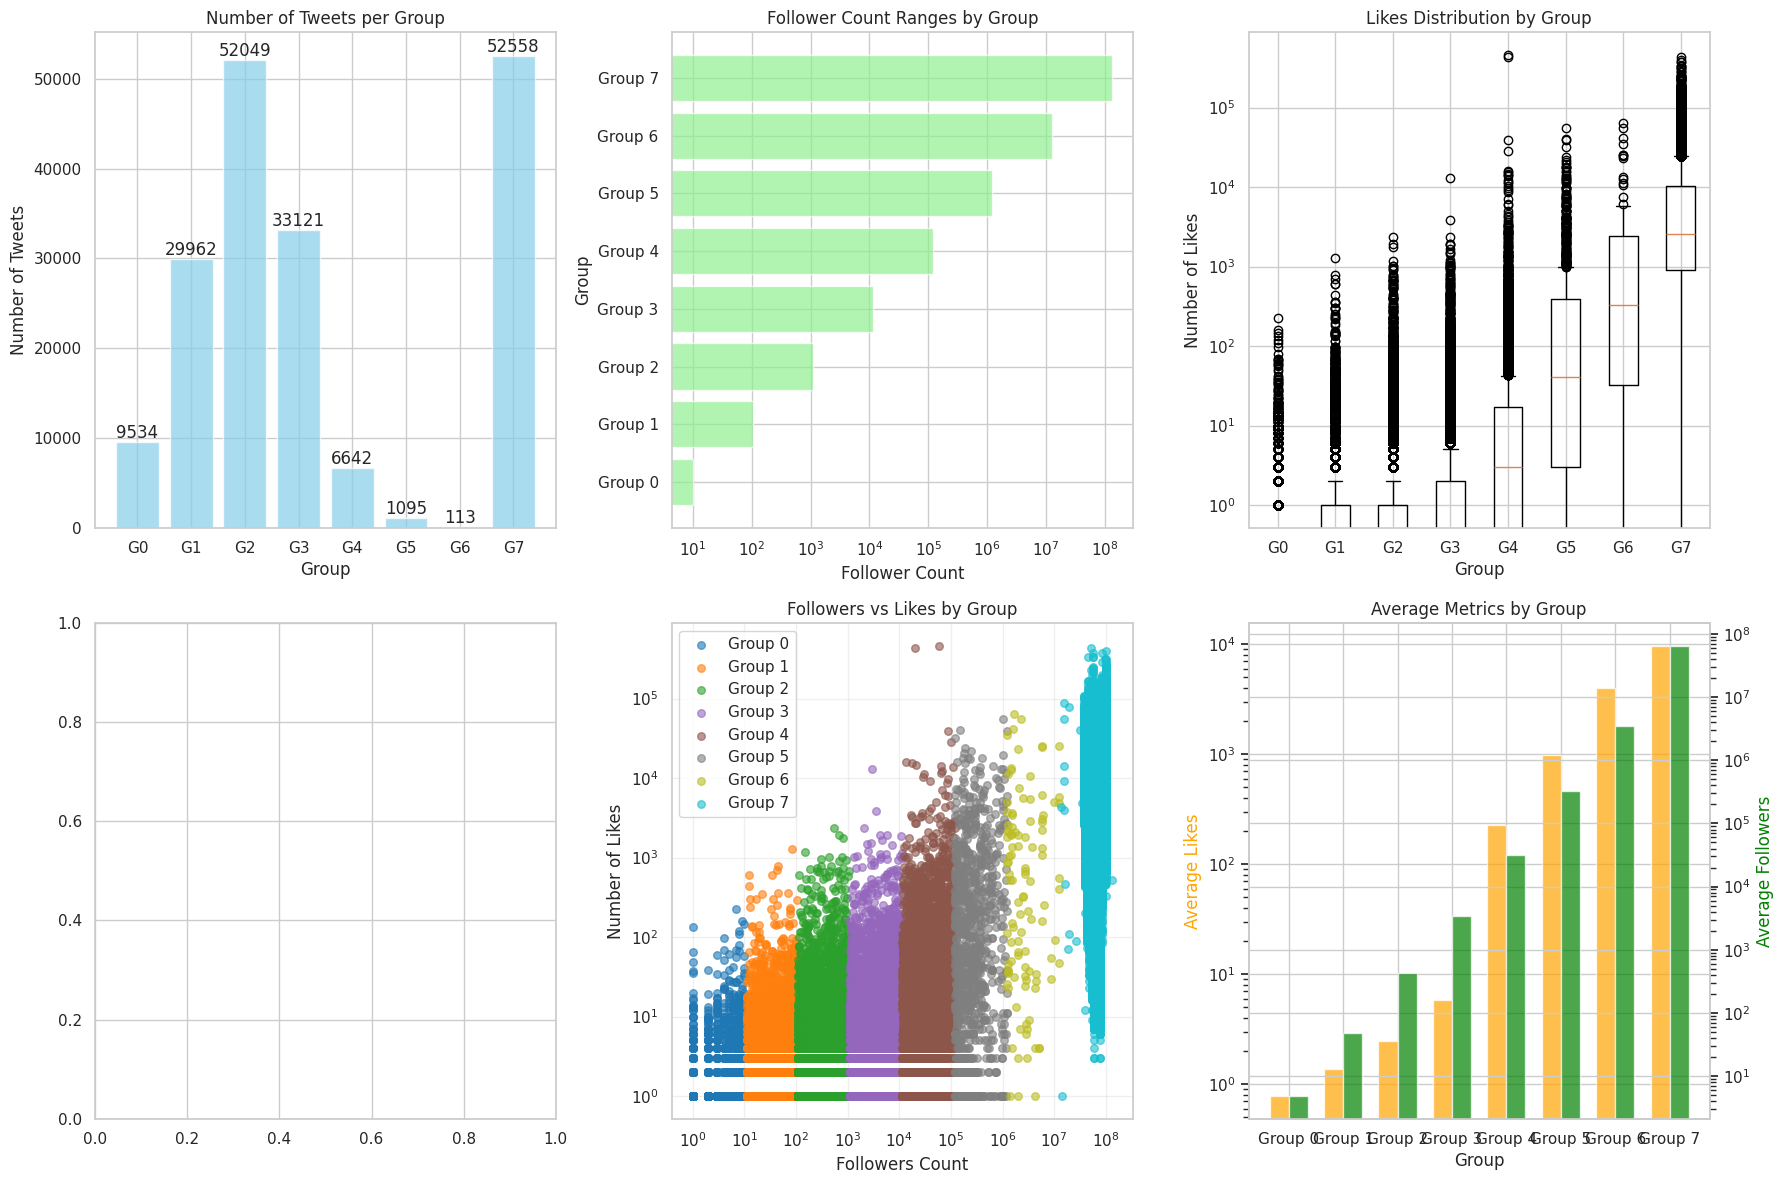


Creating visualizations for CUSTOM method...


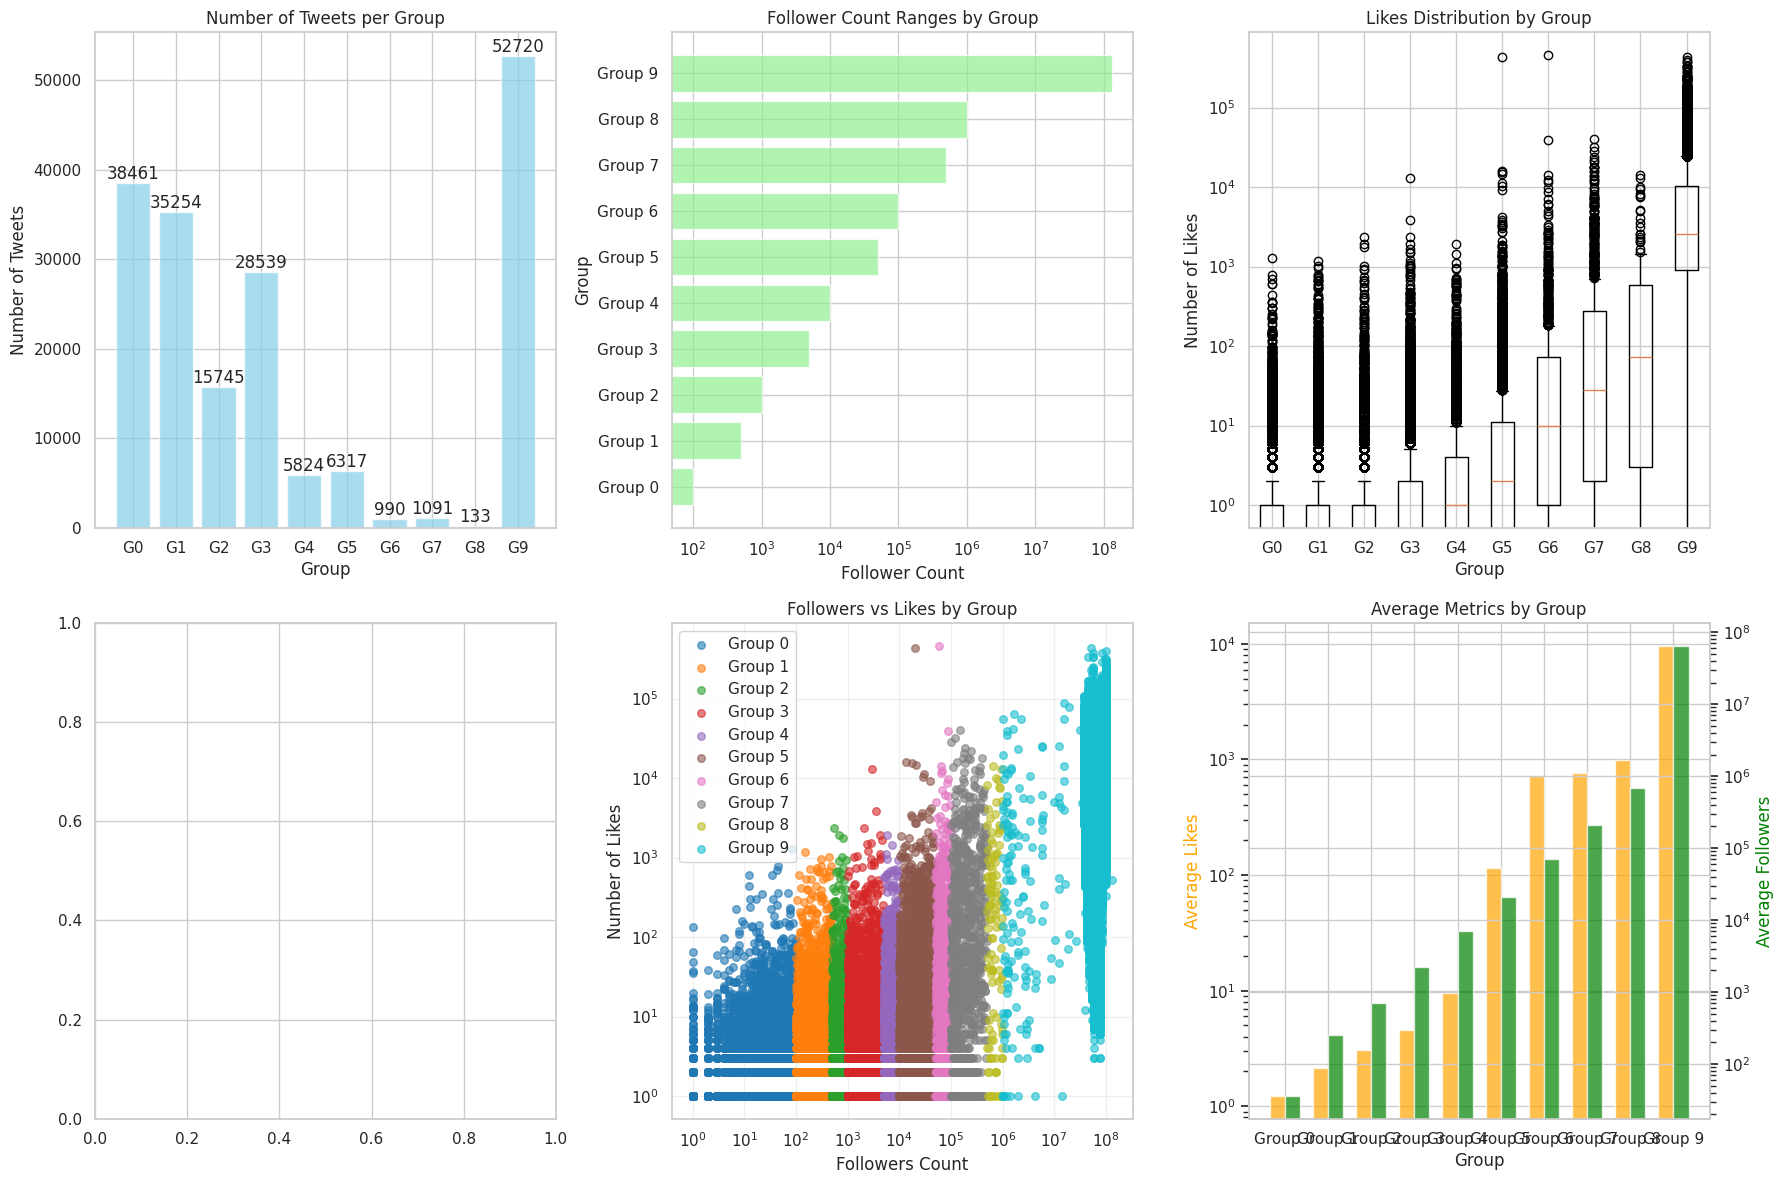


LOG-BASED ROUTING RULES:

ROUTING RULES FOR NEW TWEETS:
Group 0: 1 - 10 followers
Group 1: 10 - 106 followers
Group 2: 106 - 1,105 followers
Group 3: 1,105 - 11,428 followers
Group 4: 11,428 - 118,159 followers
Group 5: 118,159 - 1,221,693 followers
Group 6: 1,221,693 - 12,631,526 followers
Group 7: 12,631,526 - 130,601,913 followers

Python code for routing:
def route_tweet(follower_count):
    if follower_count <= 10:
        return 0  # Group 0
    elif follower_count <= 106:
        return 1  # Group 1
    elif follower_count <= 1105:
        return 2  # Group 2
    elif follower_count <= 11428:
        return 3  # Group 3
    elif follower_count <= 118159:
        return 4  # Group 4
    elif follower_count <= 1221693:
        return 5  # Group 5
    elif follower_count <= 12631526:
        return 6  # Group 6
    else:  # 12,631,526+ followers
        return 7  # Group 7

CUSTOM ROUTING RULES (RECOMMENDED):

ROUTING RULES FOR NEW TWEETS:
Group 0: 0 - 99 followers
Group 1: 100 - 

In [54]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
Data = pd.read_csv("/content/toxicity_output_combined.csv")
df = Data.copy()

def create_follower_groups(df, method='quantile', n_groups=5, custom_ranges=None):
    """
    Create follower count groups for model routing

    Parameters:
    - method: 'quantile', 'log', 'custom', or 'kmeans'
    - n_groups: number of groups to create
    - custom_ranges: list of follower count thresholds for custom method
    """

    # Clean data first
    clean_df = df.dropna(subset=['followers_count', 'number_of_likes'])
    clean_df = clean_df[(clean_df['followers_count'] > 0) & (clean_df['number_of_likes'] >= 0)]

    print(f"Creating {n_groups} follower groups from {len(clean_df)} valid tweets")
    print(f"Follower count range: {clean_df['followers_count'].min():,} - {clean_df['followers_count'].max():,}")

    if method == 'quantile':
        # Create groups based on quantiles (equal data distribution)
        clean_df['group'] = pd.qcut(clean_df['followers_count'],
                                   q=n_groups,
                                   labels=[f'Group_{i}' for i in range(n_groups)],
                                   duplicates='drop')

        # Get the actual ranges
        ranges = []
        for i in range(n_groups):
            group_data = clean_df[clean_df['group'] == f'Group_{i}']
            if len(group_data) > 0:
                min_val = group_data['followers_count'].min()
                max_val = group_data['followers_count'].max()
                ranges.append((min_val, max_val))

    elif method == 'log':
        # Create groups based on log scale (good for wide follower ranges)
        log_followers = np.log10(clean_df['followers_count'])
        min_log = log_followers.min()
        max_log = log_followers.max()

        # Create log-spaced thresholds
        thresholds = np.logspace(min_log, max_log, n_groups + 1)
        thresholds[0] = clean_df['followers_count'].min()  # Ensure we capture the minimum

        # Assign groups
        clean_df['group'] = pd.cut(clean_df['followers_count'],
                                  bins=thresholds,
                                  labels=[f'Group_{i}' for i in range(n_groups)],
                                  include_lowest=True)

        ranges = [(int(thresholds[i]), int(thresholds[i+1])) for i in range(n_groups)]

    elif method == 'custom' and custom_ranges:
        # Use custom ranges provided by user
        thresholds = [0] + custom_ranges + [clean_df['followers_count'].max() + 1]
        clean_df['group'] = pd.cut(clean_df['followers_count'],
                                  bins=thresholds,
                                  labels=[f'Group_{i}' for i in range(len(thresholds)-1)],
                                  include_lowest=True)

        ranges = [(thresholds[i], thresholds[i+1]-1) for i in range(len(thresholds)-1)]
        ranges[-1] = (ranges[-1][0], clean_df['followers_count'].max())  # Fix last range

    elif method == 'kmeans':
        # Use K-means clustering on follower count
        followers_array = clean_df['followers_count'].values.reshape(-1, 1)

        # Use log transformation for better clustering
        log_followers_array = np.log1p(followers_array)

        scaler = StandardScaler()
        scaled_followers = scaler.fit_transform(log_followers_array)

        kmeans = KMeans(n_clusters=n_groups, random_state=42, n_init=10)
        clean_df['group'] = kmeans.fit_predict(scaled_followers)
        clean_df['group'] = clean_df['group'].apply(lambda x: f'Group_{x}')

        # Get ranges for each cluster
        ranges = []
        for i in range(n_groups):
            group_data = clean_df[clean_df['group'] == f'Group_{i}']
            if len(group_data) > 0:
                min_val = group_data['followers_count'].min()
                max_val = group_data['followers_count'].max()
                ranges.append((min_val, max_val))

    # Remove any rows that couldn't be assigned (shouldn't happen but just in case)
    clean_df = clean_df.dropna(subset=['group'])

    return clean_df, ranges

def analyze_follower_groups(df_grouped, ranges):
    """
    Analyze the created follower groups
    """
    print("FOLLOWER GROUP ANALYSIS")
    print("=" * 60)

    for i, (group_name, group_data) in enumerate(df_grouped.groupby('group')):
        min_followers, max_followers = ranges[i]

        print(f"\n{group_name}:")
        print(f"  Follower Range: {min_followers:,} - {max_followers:,}")
        print(f"  Number of tweets: {len(group_data):,}")
        print(f"  Avg likes: {group_data['number_of_likes'].mean():.0f}")
        print(f"  Median likes: {group_data['number_of_likes'].median():.0f}")
        print(f"  Likes range: {group_data['number_of_likes'].min():,} - {group_data['number_of_likes'].max():,}")

def visualize_follower_groups(df_grouped, ranges):
    """
    Create comprehensive visualizations of follower groups
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Group sizes
    group_counts = df_grouped['group'].value_counts().sort_index()
    bars = axes[0,0].bar(range(len(group_counts)), group_counts.values, color='skyblue', alpha=0.7)
    axes[0,0].set_xlabel('Group')
    axes[0,0].set_ylabel('Number of Tweets')
    axes[0,0].set_title('Number of Tweets per Group')
    axes[0,0].set_xticks(range(len(group_counts)))
    axes[0,0].set_xticklabels([f'G{i}' for i in range(len(group_counts))])

    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

    # 2. Follower ranges visualization
    range_starts = [r[0] for r in ranges]
    range_ends = [r[1] for r in ranges]

    axes[0,1].barh(range(len(ranges)), range_ends, color='lightgreen', alpha=0.7)
    axes[0,1].set_xlabel('Follower Count')
    axes[0,1].set_ylabel('Group')
    axes[0,1].set_title('Follower Count Ranges by Group')
    axes[0,1].set_xscale('log')
    axes[0,1].set_yticks(range(len(ranges)))
    axes[0,1].set_yticklabels([f'Group {i}' for i in range(len(ranges))])

    # 3. Likes distribution by group
    axes[0,2].boxplot([df_grouped[df_grouped['group'] == f'Group_{i}']['number_of_likes']
                      for i in range(len(ranges))],
                     labels=[f'G{i}' for i in range(len(ranges))])
    axes[0,2].set_xlabel('Group')
    axes[0,2].set_ylabel('Number of Likes')
    axes[0,2].set_title('Likes Distribution by Group')
    axes[0,2].set_yscale('log')



    # 5. Scatter plot: Followers vs Likes colored by group
    colors = plt.cm.tab10(np.linspace(0, 1, len(ranges)))
    for i, color in enumerate(colors):
        group_data = df_grouped[df_grouped['group'] == f'Group_{i}']
        axes[1,1].scatter(group_data['followers_count'], group_data['number_of_likes'],
                         c=[color], label=f'Group {i}', alpha=0.6, s=30)

    axes[1,1].set_xlabel('Followers Count')
    axes[1,1].set_ylabel('Number of Likes')
    axes[1,1].set_title('Followers vs Likes by Group')
    axes[1,1].set_xscale('log')
    axes[1,1].set_yscale('log')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # 6. Average metrics by group
    group_stats = df_grouped.groupby('group').agg({
        'number_of_likes': 'mean',
        'followers_count': 'mean'
    })

    x = range(len(group_stats))
    width = 0.35

    axes[1,2].bar([i - width/2 for i in x], group_stats['number_of_likes'], width,
                 label='Avg Likes', alpha=0.7, color='orange')

    # Secondary y-axis for followers
    ax2 = axes[1,2].twinx()
    ax2.bar([i + width/2 for i in x], group_stats['followers_count'], width,
           label='Avg Followers', alpha=0.7, color='green')

    axes[1,2].set_xlabel('Group')
    axes[1,2].set_ylabel('Average Likes', color='orange')
    ax2.set_ylabel('Average Followers', color='green')
    axes[1,2].set_title('Average Metrics by Group')
    axes[1,2].set_xticks(x)
    axes[1,2].set_xticklabels([f'Group {i}' for i in range(len(group_stats))])
    axes[1,2].set_yscale('log')
    ax2.set_yscale('log')

    plt.tight_layout()
    plt.show()

def create_routing_function(ranges):
    """
    Create a function to route new tweets to appropriate groups based on follower count
    """
    def route_tweet(follower_count):
        """
        Route a tweet to the appropriate group based on follower count

        Args:
            follower_count (int): Number of followers for the account

        Returns:
            int: Group number (0-indexed)
        """
        for i, (min_followers, max_followers) in enumerate(ranges):
            if min_followers <= follower_count <= max_followers:
                return i

        # If not found, assign to closest group
        if follower_count < ranges[0][0]:
            return 0
        else:
            return len(ranges) - 1

    return route_tweet

def print_routing_rules(ranges):
    """
    Print the routing rules for easy reference
    """
    print("\nROUTING RULES FOR NEW TWEETS:")
    print("=" * 50)
    for i, (min_followers, max_followers) in enumerate(ranges):
        print(f"Group {i}: {min_followers:,} - {max_followers:,} followers")

    print(f"\nPython code for routing:")
    print("def route_tweet(follower_count):")
    for i, (min_followers, max_followers) in enumerate(ranges):
        if i == 0:
            print(f"    if follower_count <= {max_followers}:")
        elif i == len(ranges) - 1:
            print(f"    else:  # {min_followers:,}+ followers")
        else:
            print(f"    elif follower_count <= {max_followers}:")
        print(f"        return {i}  # Group {i}")

# Main execution
if __name__ == "__main__":
    print("Creating follower-based groups for model routing...")
    print(f"Dataset shape: {df.shape}")

    # Check data
    if 'followers_count' not in df.columns or 'number_of_likes' not in df.columns:
        print("Error: Required columns not found!")
        print(f"Available columns: {df.columns.tolist()}")
    else:
        print(f"Follower count range: {df['followers_count'].min():,} - {df['followers_count'].max():,}")

        # Try different grouping methods
        methods_to_try = {
            'quantile': 'Equal data distribution in each group',
            'log': 'Log-spaced ranges (good for wide follower ranges)',
            'custom': 'Custom ranges you define',
            'kmeans': 'K-means clustering on follower count'
        }

        print(f"\nAvailable grouping methods:")
        for method, description in methods_to_try.items():
            print(f"  {method}: {description}")

        # First, let's examine the data distribution
        print(f"\nData distribution analysis:")
        print(f"Min followers: {df['followers_count'].min():,}")
        print(f"Max followers: {df['followers_count'].max():,}")
        print(f"Median followers: {df['followers_count'].median():,}")
        print(f"Mean followers: {df['followers_count'].mean():,.0f}")

        # Show percentiles to understand the distribution
        percentiles = [10, 25, 50, 75, 90, 95, 99, 99.9]
        print(f"\nFollower count percentiles:")
        for p in percentiles:
            value = np.percentile(df['followers_count'].dropna(), p)
            print(f"  {p}th percentile: {value:,.0f}")

        # Use log method for more sensible ranges
        print(f"\nUsing LOG method with 8 groups for better distribution...")
        df_grouped, ranges = create_follower_groups(df, method='log', n_groups=8)

        # Also try custom ranges that make more business sense
        print(f"\nAlso trying CUSTOM ranges that make business sense...")
        custom_ranges = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]
        df_grouped_custom, ranges_custom = create_follower_groups(df, method='custom',
                                                                 custom_ranges=custom_ranges,
                                                                 n_groups=len(custom_ranges)+1)

        # Analyze both grouping approaches
        print(f"\n" + "="*60)
        print(f"LOG-BASED GROUPING RESULTS:")
        analyze_follower_groups(df_grouped, ranges)

        print(f"\n" + "="*60)
        print(f"CUSTOM BUSINESS-LOGIC GROUPING RESULTS:")
        analyze_follower_groups(df_grouped_custom, ranges_custom)

        # Create visualizations for both
        print(f"\nCreating visualizations for LOG method...")
        visualize_follower_groups(df_grouped, ranges)

        print(f"\nCreating visualizations for CUSTOM method...")
        visualize_follower_groups(df_grouped_custom, ranges_custom)

        # Print routing rules for both
        print(f"\n" + "="*60)
        print(f"LOG-BASED ROUTING RULES:")
        print_routing_rules(ranges)

        print(f"\n" + "="*60)
        print(f"CUSTOM ROUTING RULES (RECOMMENDED):")
        print_routing_rules(ranges_custom)

        # Create routing function for the recommended approach
        route_function = create_routing_function(ranges_custom)

        # Test the routing function with more examples
        print(f"\nTesting CUSTOM routing function:")
        test_followers = [10, 75, 250, 750, 2500, 7500, 25000, 75000, 250000, 750000, 5000000]
        for followers in test_followers:
            group = route_function(followers)
            min_f, max_f = ranges_custom[group]
            print(f"  {followers:,} followers → Group {group} ({min_f:,} - {max_f:,})")


# Starting
we tried also the kmeans and reason partioning  

Loading dataset...
Cleaning data...
Original dataset: 186,740 rows
Clean dataset: 185,074 rows

Group Distribution:
Group 0: 1 - 10 followers -> 9,534 tweets
Group 1: 11 - 106 followers -> 29,962 tweets
Group 2: 107 - 1,105 followers -> 52,049 tweets
Group 3: 1,106 - 11,428 followers -> 33,121 tweets
Group 4: 11,429 - 118,159 followers -> 6,642 tweets
Group 5: 118,160 - 1,221,693 followers -> 1,095 tweets
Group 6: 1,221,694 - 12,631,526 followers -> 113 tweets
Group 7: 12,631,527 - 30,000,000 followers -> 13 tweets
Group 8: 30,000,001 - 80,000,000 followers -> 39,851 tweets
Group 9: 80,000,001 - 130,601,913 followers -> 12,694 tweets

STARTING DECISION TREE ANALYSIS FOR ALL FOLLOWER GROUPS

TRAINING MODEL FOR GROUP 0
Group 0 Info:
  - Sample size: 9,534
  - Features used: ['number_of_shares', 'followers_count', 'sentiment', 'log_followers', 'followers_squared', 'followers_sqrt', 'followers_zscore', 'sentiment_score']
  - Target range: 0 - 225
  - Target mean: 0.78
  - Target std: 5.01


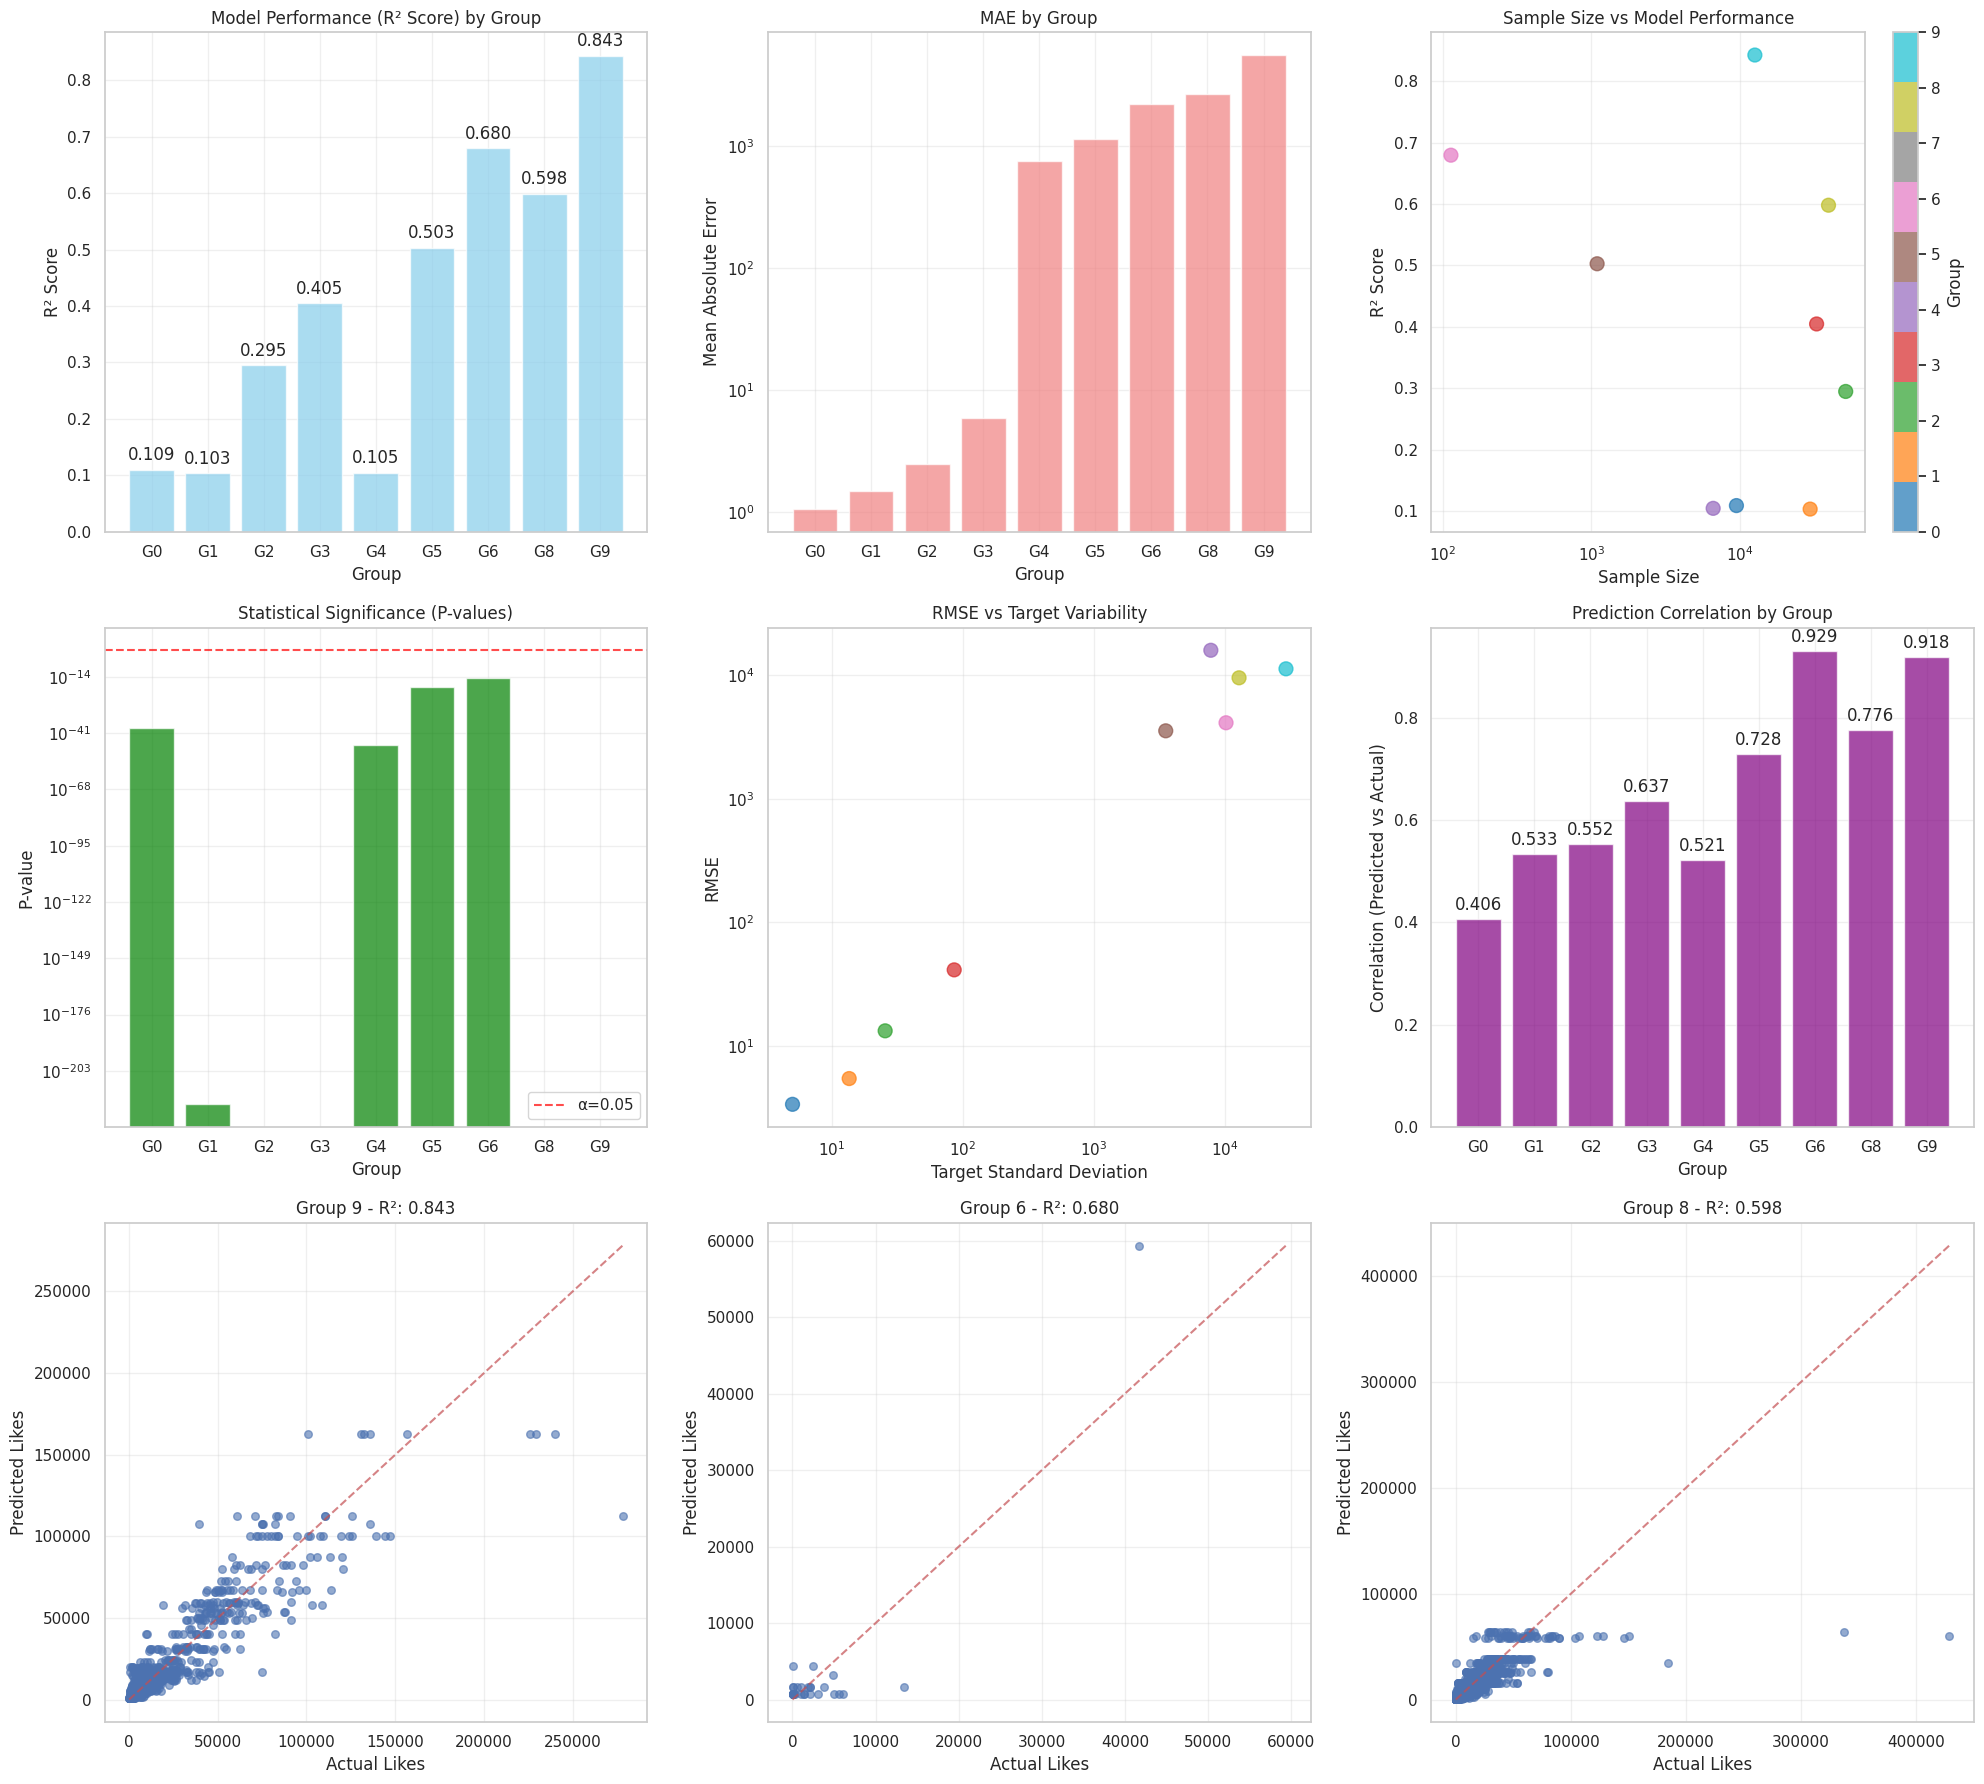


MODEL PERFORMANCE SUMMARY
 Group  Sample Size  Test MAE     Test MSE  Test RMSE  Test R²  P-value  Correlation  Target Mean  Target Std
     0         9534    1.0569 1.143270e+01     3.3812   0.1092      0.0       0.4061       0.7799      5.0085
     1        29962    1.4996 2.983490e+01     5.4621   0.1035      0.0       0.5331       1.3756     13.5534
     2        52049    2.4851 1.763641e+02    13.2802   0.2949      0.0       0.5521       2.4516     25.5032
     3        33121    5.8454 1.706348e+03    41.3080   0.4048      0.0       0.6366       5.8341     85.7648
     4         6642  749.1159 2.508960e+08 15839.6974   0.1047      0.0       0.5213     226.0456   7788.0881
     5         1095 1128.6851 1.251118e+07  3537.1144   0.5028      0.0       0.7281     985.5425   3526.1607
     6          113 2190.6559 1.688068e+07  4108.6099   0.6795      0.0       0.9293    3992.1681  10172.4712
     8        39851 2632.4797 9.000857e+07  9487.2847   0.5981      0.0       0.7763    6955.

In [55]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
print("Loading dataset...")
Data = pd.read_csv("/content/toxicity_output_combined.csv")
df = Data.copy()

# Clean the data
print("Cleaning data...")
df_clean = df.dropna(subset=['followers_count', 'number_of_likes'])
df_clean = df_clean[(df_clean['followers_count'] > 0) & (df_clean['number_of_likes'] >= 0)]

print(f"Original dataset: {len(df):,} rows")
print(f"Clean dataset: {len(df_clean):,} rows")

# Define the log-based groups manually (based on your preferred output)

#BY KMEANS
group_ranges = [

      (1, 10),           # Group 0
      (11, 106),         # Group 1
      (107, 1105),       # Group 2
      (1106, 11428),     # Group 3
      (11429, 118159),   # Group 4
      (118160, 1221693), # Group 5
      (1221694, 12631526), # Group 6
      (12631527, 30000000),   # Group 7a
      (30000001, 80000000),   # Group 7b
      (80000001, 130601913)   # Group 7c
]
#BY REASON
"""
group_ranges = [
    (0, 99),           # Group 0
    (100, 499),         # Group 1
    (500, 999),       # Group 2
    (1000 , 4999),     # Group 3
    (5000 , 9999),   # Group 4
    (10000 , 49999), # Group 5
    (100000 , 499999), # Group 6
    (500000 , 999999), # Group 7
    (1000000 , 19999999), # Group 8
    (20000000 , 40000000 ), # Group 8
    (40000001 , 130601913) # Group 9
  ]
"""
# Assign groups based on follower count
def assign_group(follower_count):
    for i, (min_f, max_f) in enumerate(group_ranges):
        if min_f <= follower_count <= max_f:
            return f'Group_{i}'
    return 'Group_7'  # Default to last group for outliers

df_clean['group'] = df_clean['followers_count'].apply(assign_group)

# Show group distribution
print("\nGroup Distribution:")
print("="*50)
for i, (min_f, max_f) in enumerate(group_ranges):
    group_data = df_clean[df_clean['group'] == f'Group_{i}']
    print(f"Group {i}: {min_f:,} - {max_f:,} followers -> {len(group_data):,} tweets")

def create_features_for_modeling(df_group):
    """Create features for the regression model"""
    features_df = df_group.copy()

    # Basic features
    features_df['log_followers'] = np.log1p(features_df['followers_count'])
    features_df['followers_squared'] = features_df['followers_count'] ** 2
    features_df['followers_sqrt'] = np.sqrt(features_df['followers_count'])

    # Statistical features within the group
    if features_df['followers_count'].std() > 0:
        features_df['followers_zscore'] = (features_df['followers_count'] - features_df['followers_count'].mean()) / features_df['followers_count'].std()
    else:
        features_df['followers_zscore'] = 0
    if 'sentiment' in features_df.columns:
        features_df['sentiment_score'] = features_df['sentiment']

    # Clean any infinite or NaN values
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    features_df = features_df.fillna(0)

    return features_df

def train_decision_tree_model(df_group, group_id):
    """Train a Decision Tree model for a specific group and evaluate it"""
    print(f"\n{'='*60}")
    print(f"TRAINING MODEL FOR GROUP {group_id}")
    print(f"{'='*60}")

    # Check if we have enough data
    if len(df_group) < 20:
        print(f"Not enough data for Group {group_id} (only {len(df_group)} samples)")
        return None

    # Create features
    features_df = create_features_for_modeling(df_group)

    # Define feature columns (exclude target and group identifier)
    feature_columns = [col for col in features_df.columns
                      if col not in ['number_of_likes', 'group', 'tweet'] and not col.startswith('Unnamed')]

    # Ensure we have valid features
    if len(feature_columns) == 0:
        print(f"No valid features found for Group {group_id}")
        return None

    print(f"Group {group_id} Info:")
    print(f"  - Sample size: {len(df_group):,}")
    print(f"  - Features used: {feature_columns}")
    print(f"  - Target range: {df_group['number_of_likes'].min()} - {df_group['number_of_likes'].max()}")
    print(f"  - Target mean: {df_group['number_of_likes'].mean():.2f}")
    print(f"  - Target std: {df_group['number_of_likes'].std():.2f}")

    # Prepare data
    X = features_df[feature_columns]
    y = features_df['number_of_likes']

    # Check for constant targets (no variance)
    if y.std() == 0:
        print(f"No variance in target variable for Group {group_id}")
        return None

    # Split data
    test_size = min(0.3, max(0.1, 100/len(X)))  # Adaptive test size
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    print(f"  - Training samples: {len(X_train):,}")
    print(f"  - Testing samples: {len(X_test):,}")

    # Train Decision Tree model with optimized parameters
    dt_model = DecisionTreeRegressor(
        max_depth=min(10, max(3, len(X_train)//50)),
        min_samples_split=max(2, len(X_train)//100),
        min_samples_leaf=max(1, len(X_train)//200),
        random_state=42,
        max_features='sqrt' if len(feature_columns) > 1 else None
    )

    try:
        dt_model.fit(X_train, y_train)

        # Make predictions
        y_pred_train = dt_model.predict(X_train)
        y_pred_test = dt_model.predict(X_test)

        # Calculate metrics
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)

        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)

        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)

        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)

        # Statistical significance test (Pearson correlation)
        if len(y_test) > 2:
            correlation, p_value = stats.pearsonr(y_test, y_pred_test)
        else:
            correlation, p_value = 0, 1

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': dt_model.feature_importances_
        }).sort_values('importance', ascending=False)

        results = {
            'group_id': group_id,
            'model': dt_model,
            'sample_size': len(df_group),
            'train_size': len(X_train),
            'test_size': len(X_test),
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'correlation': correlation,
            'p_value': p_value,
            'feature_importance': feature_importance,
            'X_test': X_test,
            'y_test': y_test,
            'y_pred_test': y_pred_test,
            'target_mean': y.mean(),
            'target_std': y.std(),
            'feature_columns': feature_columns
        }

        # Print results
        print(f"\nMODEL PERFORMANCE:")
        print(f"  Training Metrics:")
        print(f"    - MAE: {train_mae:.2f}")
        print(f"    - MSE: {train_mse:.2f}")
        print(f"    - RMSE: {train_rmse:.2f}")
        print(f"    - R²: {train_r2:.4f}")

        print(f"  Testing Metrics:")
        print(f"    - MAE: {test_mae:.2f}")
        print(f"    - MSE: {test_mse:.2f}")
        print(f"    - RMSE: {test_rmse:.2f}")
        print(f"    - R²: {test_r2:.4f}")

        print(f"  Statistical Significance:")
        print(f"    - Correlation: {correlation:.4f}")
        print(f"    - P-value: {p_value:.6f}")
        print(f"    - Significant: {'Yes' if p_value < 0.05 else 'No'}")

        print(f"\n  Top 5 Important Features:")
        for idx, row in feature_importance.head().iterrows():
            print(f"    {row['feature']}: {row['importance']:.4f}")

        return results

    except Exception as e:
        print(f"Error training model for Group {group_id}: {str(e)}")
        return None

def visualize_model_results(all_results):
    """Create comprehensive visualizations of all models"""
    if not all_results:
        print("No results to visualize")
        return

    # Filter out None results
    valid_results = [r for r in all_results if r is not None]

    if not valid_results:
        print("No valid results to visualize")
        return

    # Create summary dataframe
    summary_data = []
    for result in valid_results:
        summary_data.append({
            'Group': result['group_id'],
            'Sample Size': result['sample_size'],
            'Test MAE': result['test_mae'],
            'Test MSE': result['test_mse'],
            'Test RMSE': result['test_rmse'],
            'Test R²': result['test_r2'],
            'P-value': result['p_value'],
            'Correlation': result['correlation'],
            'Target Mean': result['target_mean'],
            'Target Std': result['target_std']
        })

    summary_df = pd.DataFrame(summary_data)

    # Create comprehensive visualizations
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))

    # 1. Model Performance Comparison (R²)
    ax1 = axes[0, 0]
    x_pos = range(len(summary_df))
    bars = ax1.bar(x_pos, summary_df['Test R²'], color='skyblue', alpha=0.7)
    ax1.set_xlabel('Group')
    ax1.set_ylabel('R² Score')
    ax1.set_title('Model Performance (R² Score) by Group')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f'G{g}' for g in summary_df['Group']])
    for i, v in enumerate(summary_df['Test R²']):
        ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    ax1.grid(True, alpha=0.3)

    # 2. MAE Comparison
    ax2 = axes[0, 1]
    ax2.bar(x_pos, summary_df['Test MAE'], color='lightcoral', alpha=0.7)
    ax2.set_xlabel('Group')
    ax2.set_ylabel('Mean Absolute Error')
    ax2.set_title('MAE by Group')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'G{g}' for g in summary_df['Group']])
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)

    # 3. Sample Size vs Performance
    ax3 = axes[0, 2]
    scatter = ax3.scatter(summary_df['Sample Size'], summary_df['Test R²'],
                         c=summary_df['Group'], cmap='tab10', s=100, alpha=0.7)
    ax3.set_xlabel('Sample Size')
    ax3.set_ylabel('R² Score')
    ax3.set_title('Sample Size vs Model Performance')
    ax3.set_xscale('log')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Group')

    # 4. P-values
    ax4 = axes[1, 0]
    colors = ['green' if p < 0.05 else 'red' for p in summary_df['P-value']]
    bars = ax4.bar(x_pos, summary_df['P-value'], color=colors, alpha=0.7)
    ax4.set_xlabel('Group')
    ax4.set_ylabel('P-value')
    ax4.set_title('Statistical Significance (P-values)')
    ax4.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α=0.05')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([f'G{g}' for g in summary_df['Group']])
    ax4.set_yscale('log')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. RMSE vs Target Variability
    ax5 = axes[1, 1]
    ax5.scatter(summary_df['Target Std'], summary_df['Test RMSE'],
               c=summary_df['Group'], cmap='tab10', s=100, alpha=0.7)
    ax5.set_xlabel('Target Standard Deviation')
    ax5.set_ylabel('RMSE')
    ax5.set_title('RMSE vs Target Variability')
    ax5.set_xscale('log')
    ax5.set_yscale('log')
    ax5.grid(True, alpha=0.3)

    # 6. Correlation values
    ax6 = axes[1, 2]
    ax6.bar(x_pos, summary_df['Correlation'], color='purple', alpha=0.7)
    ax6.set_xlabel('Group')
    ax6.set_ylabel('Correlation (Predicted vs Actual)')
    ax6.set_title('Prediction Correlation by Group')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels([f'G{g}' for g in summary_df['Group']])
    for i, v in enumerate(summary_df['Correlation']):
        ax6.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    ax6.grid(True, alpha=0.3)

    # 7-9. Prediction vs Actual for top 3 performing groups
    valid_results_sorted = sorted(valid_results, key=lambda x: x['test_r2'], reverse=True)
    top_results = valid_results_sorted[:3]

    for i, result in enumerate(top_results):
        ax = axes[2, i]
        ax.scatter(result['y_test'], result['y_pred_test'], alpha=0.6, s=30)

        # Add perfect prediction line
        min_val = min(result['y_test'].min(), result['y_pred_test'].min())
        max_val = max(result['y_test'].max(), result['y_pred_test'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)

        ax.set_xlabel('Actual Likes')
        ax.set_ylabel('Predicted Likes')
        ax.set_title(f'Group {result["group_id"]} - R²: {result["test_r2"]:.3f}')
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(len(top_results), 3):
        axes[2, i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\n" + "="*100)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*100)
    print(summary_df.round(4).to_string(index=False))

    # Statistical insights
    print(f"\n" + "="*100)
    print("KEY INSIGHTS:")
    print("="*100)

    best_r2 = summary_df.loc[summary_df['Test R²'].idxmax()]
    worst_r2 = summary_df.loc[summary_df['Test R²'].idxmin()]

    print(f"🏆 Best performing model: Group {best_r2['Group']} (R² = {best_r2['Test R²']:.4f})")
    print(f"📉 Worst performing model: Group {worst_r2['Group']} (R² = {worst_r2['Test R²']:.4f})")

    significant_models = summary_df[summary_df['P-value'] < 0.05]
    print(f"✅ Statistically significant models: {len(significant_models)}/{len(summary_df)}")

    avg_r2 = summary_df['Test R²'].mean()
    print(f"📊 Average R² across all groups: {avg_r2:.4f}")

    # Feature importance analysis
    print(f"\n📋 FEATURE IMPORTANCE ACROSS GROUPS:")
    all_features = {}
    for result in valid_results:
        for _, row in result['feature_importance'].iterrows():
            feature = row['feature']
            importance = row['importance']
            if feature not in all_features:
                all_features[feature] = []
            all_features[feature].append(importance)

    # Calculate average importance
    avg_importance = {feature: np.mean(importances) for feature, importances in all_features.items()}
    sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)

    for feature, avg_imp in sorted_features[:5]:
        print(f"  {feature}: {avg_imp:.4f} (avg across groups)")

    return summary_df

# Main execution
print("\n" + "="*80)
print("STARTING DECISION TREE ANALYSIS FOR ALL FOLLOWER GROUPS")
print("="*80)

all_results = []

# Train model for each group
for i in range(len(group_ranges)):  # Groups 0-7
    group_data = df_clean[df_clean['group'] == f'Group_{i}']

    if len(group_data) > 0:
        result = train_decision_tree_model(group_data, i)
        all_results.append(result)
    else:
        print(f"\nNo data found for Group {i}")
        all_results.append(None)

# Visualize all results
print(f"\n" + "="*80)
print("CREATING COMPREHENSIVE VISUALIZATIONS...")
print("="*80)

summary_df = visualize_model_results(all_results)


# Removing Outliers
main model here!

Loading dataset...
Cleaning data...
Original dataset: 186,740 rows
Clean dataset: 186,740 rows

Analyzing Group 7 data distribution for better partitioning...
Total Group 7 data: 52,558 tweets
Suggested cutpoints for equal data distribution:
  33rd percentile: 52,000,000
  67th percentile: 77,000,000
Alternative business-logic cutpoints:
  25M followers: 25,000,000
  60M followers: 60,000,000

Testing data distribution with percentile-based splits:
  Group 7a: 12,631,527 - 52,000,000 -> 18,321 tweets
  Group 7b: 52,000,001 - 77,000,000 -> 18,466 tweets
  Group 7c: 77,000,001 - 130,601,913 -> 15,771 tweets

Testing data distribution with business-logic splits:
  Group 7a: 12,631,527 - 25,000,000 -> 12 tweets
  Group 7b: 25,000,001 - 60,000,000 -> 31,299 tweets
  Group 7c: 60,000,001 - 130,601,913 -> 21,247 tweets

Balance analysis (lower = better):
  Percentile-based balance: 1237.7
  Business-logic balance: 13042.0
  -> Using PERCENTILE-BASED splits for better balance

Final Group 7 su

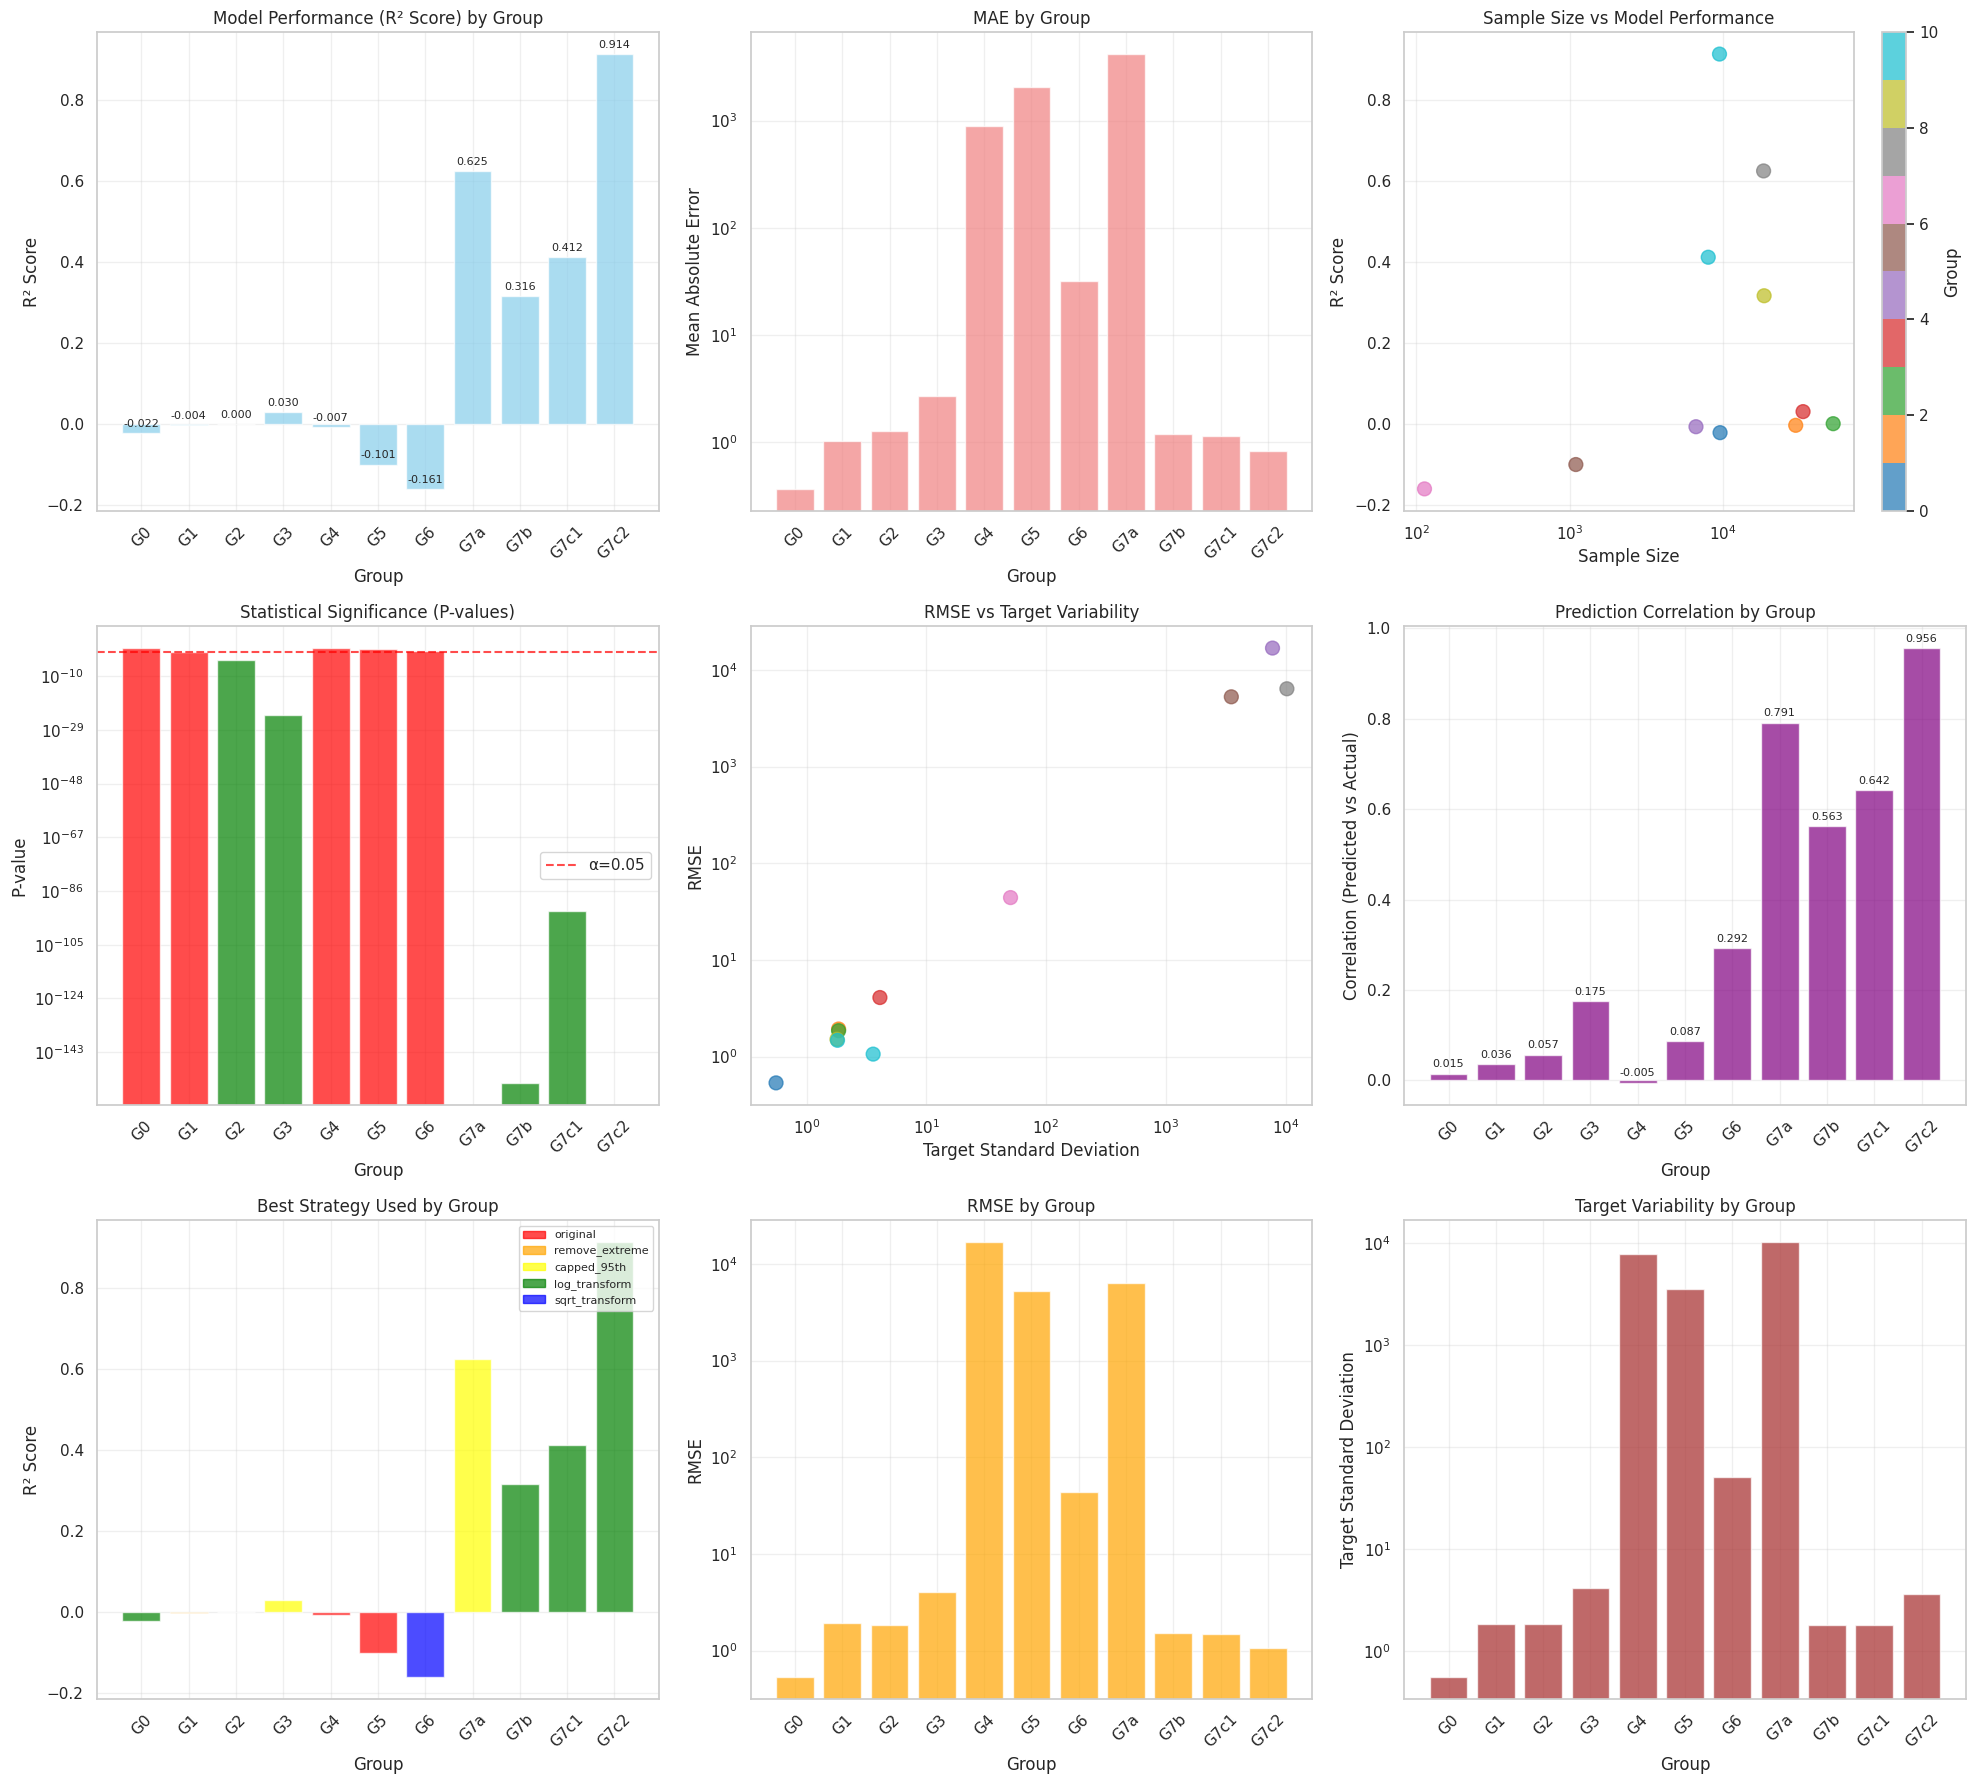


MODEL PERFORMANCE SUMMARY (WITH SUB-GROUPS)
Group  Sample Size  Test MAE     Test MSE  Test RMSE  Test R²  P-value  Correlation  Target Mean  Target Std       Strategy
    0         9534    0.3670 2.848000e-01     0.5336  -0.0221   0.6454       0.0149       0.2433      0.5555  log_transform
    1        29664    1.0247 3.706600e+00     1.9253  -0.0040   0.0503       0.0359       0.7144      1.8497 remove_extreme
    2        52049    1.2735 3.421600e+00     1.8497   0.0001   0.0000       0.0567       1.0281      1.8498    capped_95th
    3        33121    2.7030 1.661750e+01     4.0765   0.0299   0.0000       0.1753       2.2130      4.0937    capped_95th
    4         6642  888.2512 2.823139e+08 16802.1988  -0.0074   0.8882      -0.0055     226.0456   7788.0881       original
    5         1095 2069.5850 2.770261e+07  5263.3270  -0.1009   0.3667       0.0869     985.5425   3526.1607       original
    6          113   31.8934 1.942494e+03    44.0737  -0.1612   0.0935       0.2923    

In [57]:
#main model


import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
print("Loading dataset...")
Data = pd.read_csv("/content/toxicity_output_combined.csv")
df = Data.copy()

# Clean the data
print("Cleaning data...")
df_clean = df.dropna(subset=['followers_count', 'number_of_likes'])

print(f"Original dataset: {len(df):,} rows")
print(f"Clean dataset: {len(df_clean):,} rows")

# First, let's analyze the actual distribution of Group 7 data to make better splits
print("\nAnalyzing Group 7 data distribution for better partitioning...")
group_7_data = df_clean[(df_clean['followers_count'] >= 12631527) & (df_clean['followers_count'] <= 130601913)]
print(f"Total Group 7 data: {len(group_7_data):,} tweets")

if len(group_7_data) > 0:
    # Calculate percentiles to create more balanced groups
    percentiles = [33.33, 66.67]  # Split into roughly equal thirds
    cutpoints = []
    for p in percentiles:
        cutpoint = group_7_data['followers_count'].quantile(p/100)
        cutpoints.append(int(cutpoint))

    print(f"Suggested cutpoints for equal data distribution:")
    print(f"  33rd percentile: {cutpoints[0]:,}")
    print(f"  67th percentile: {cutpoints[1]:,}")

    # Alternative: Use meaningful business breakpoints
    business_cutpoints = [25000000, 60000000]  # 25M and 60M followers

    print(f"Alternative business-logic cutpoints:")
    print(f"  25M followers: {business_cutpoints[0]:,}")
    print(f"  60M followers: {business_cutpoints[1]:,}")

    # Test both approaches
    print(f"\nTesting data distribution with percentile-based splits:")
    ranges_percentile = [
        (12631527, cutpoints[0]),
        (cutpoints[0] + 1, cutpoints[1]),
        (cutpoints[1] + 1, 130601913)
    ]

    for i, (min_f, max_f) in enumerate(ranges_percentile):
        count = len(group_7_data[(group_7_data['followers_count'] >= min_f) &
                                (group_7_data['followers_count'] <= max_f)])
        print(f"  Group 7{chr(97+i)}: {min_f:,} - {max_f:,} -> {count:,} tweets")

    print(f"\nTesting data distribution with business-logic splits:")
    ranges_business = [
        (12631527, business_cutpoints[0]),
        (business_cutpoints[0] + 1, business_cutpoints[1]),
        (business_cutpoints[1] + 1, 130601913)
    ]

    for i, (min_f, max_f) in enumerate(ranges_business):
        count = len(group_7_data[(group_7_data['followers_count'] >= min_f) &
                                (group_7_data['followers_count'] <= max_f)])
        print(f"  Group 7{chr(97+i)}: {min_f:,} - {max_f:,} -> {count:,} tweets")

    # Choose the better approach (more balanced)
    percentile_counts = [len(group_7_data[(group_7_data['followers_count'] >= r[0]) &
                                         (group_7_data['followers_count'] <= r[1])])
                        for r in ranges_percentile]
    business_counts = [len(group_7_data[(group_7_data['followers_count'] >= r[0]) &
                                       (group_7_data['followers_count'] <= r[1])])
                      for r in ranges_business]

    # Calculate balance (lower standard deviation = more balanced)
    percentile_balance = np.std(percentile_counts)
    business_balance = np.std(business_counts)

    print(f"\nBalance analysis (lower = better):")
    print(f"  Percentile-based balance: {percentile_balance:.1f}")
    print(f"  Business-logic balance: {business_balance:.1f}")

    if percentile_balance < business_balance:
        print(f"  -> Using PERCENTILE-BASED splits for better balance")
        chosen_ranges = ranges_percentile
        chosen_method = "percentile"
    else:
        print(f"  -> Using BUSINESS-LOGIC splits")
        chosen_ranges = ranges_business
        chosen_method = "business"

    # Update the group ranges with the chosen approach
    group_ranges = [
        (1, 10),           # Group 0
        (11, 106),         # Group 1
        (107, 1105),       # Group 2
        (1106, 11428),     # Group 3
        (11429, 118159),   # Group 4
        (118160, 1221693), # Group 5
        (1221694, 12631526), # Group 6
        chosen_ranges[0],    # Group 7a
        chosen_ranges[1],    # Group 7b
        chosen_ranges[2]     # Group 7c
    ]

    print(f"\nFinal Group 7 sub-group ranges ({chosen_method}-based):")
    for i, (min_f, max_f) in enumerate(chosen_ranges):
        print(f"  Group 7{chr(97+i)}: {min_f:,} - {max_f:,} followers")

else:
    print("No data found in Group 7 range!")
    # Keep original ranges as fallback
    group_ranges = [
        (1, 10),           # Group 0
        (11, 106),         # Group 1
        (107, 1105),       # Group 2
        (1106, 11428),     # Group 3
        (11429, 118159),   # Group 4
        (118160, 1221693), # Group 5
        (1221694, 12631526), # Group 6
        (12631527, 30000000),   # Group 7a
        (30000001, 80000000),   # Group 7b
        (80000001, 130601913)   # Group 7c
    ]

# Updated group assignment function
def assign_group(follower_count):
    for i, (min_f, max_f) in enumerate(group_ranges):
        if min_f <= follower_count <= max_f:
            if i >= 7:  # Sub-groups of original Group 7
                return f'Group_7{chr(97+i-7)}'  # 7a, 7b, 7c
            else:
                return f'Group_{i}'
    return 'Group_7c'  # Default to last sub-group for outliers

df_clean['group'] = df_clean['followers_count'].apply(assign_group)

# Show group distribution with sub-groups
print("\nGroup Distribution (with Group 7 sub-groups):")
print("="*60)
group_names = []
total_original_group_7 = 0

for i in range(7):
    min_f, max_f = group_ranges[i]
    group_data = df_clean[df_clean['group'] == f'Group_{i}']
    print(f"Group {i}: {min_f:,} - {max_f:,} followers -> {len(group_data):,} tweets")
    group_names.append(f'Group_{i}')

# Sub-groups for original Group 7
print("\nOriginal Group 7 breakdown:")
original_group_7_data = df_clean[(df_clean['followers_count'] >= 12631527) & (df_clean['followers_count'] <= 130601913)]
total_original_group_7 = len(original_group_7_data)
print(f"Total original Group 7: {total_original_group_7:,} tweets")

sub_group_labels = ['7a', '7b', '7c']
sub_group_totals = []
for i, label in enumerate(sub_group_labels):
    group_idx = 7 + i
    min_f, max_f = group_ranges[group_idx]
    group_data = df_clean[df_clean['group'] == f'Group_{label}']
    print(f"Group {label}: {min_f:,} - {max_f:,} followers -> {len(group_data):,} tweets")
    sub_group_totals.append(len(group_data))
    group_names.append(f'Group_{label}')

print(f"\nSub-groups total: {sum(sub_group_totals):,} tweets")
print(f"Difference from original: {total_original_group_7 - sum(sub_group_totals):,} tweets")

# Analyzing Group 7c for further partitioning
print("\nAnalyzing Group 7c for further partitioning...")
group_7c_data = df_clean[df_clean['group'] == 'Group_7c']
print(f"Current Group 7c size: {len(group_7c_data):,} tweets")

if len(group_7c_data) > 1000:  # Only split if we have enough data
    # Split Group 7c at median follower count
    median_followers_7c = group_7c_data['followers_count'].median()
    print(f"Group 7c median followers: {median_followers_7c:,}")

    # Create new assignment function that handles 7c split
    def assign_group_with_7c_split(follower_count):
        for i, (min_f, max_f) in enumerate(group_ranges):
            if min_f <= follower_count <= max_f:
                if i == 9:  # Original Group 7c range
                    if follower_count <= median_followers_7c:
                        return 'Group_7c1'
                    else:
                        return 'Group_7c2'
                elif i >= 7:  # Other Group 7 sub-groups
                    return f'Group_7{chr(97+i-7)}'  # 7a, 7b
                else:
                    return f'Group_{i}'
        return 'Group_7c2'  # Default to last group

    # Reassign groups with the new split
    df_clean['group'] = df_clean['followers_count'].apply(assign_group_with_7c_split)

    # Update the group names list
    all_group_names = [f'Group_{i}' for i in range(7)] + ['Group_7a', 'Group_7b', 'Group_7c1', 'Group_7c2']

    # Show new distribution
    print(f"\nNew Group 7c split:")
    group_7c1_data = df_clean[df_clean['group'] == 'Group_7c1']
    group_7c2_data = df_clean[df_clean['group'] == 'Group_7c2']
    print(f"Group 7c1: {len(group_7c1_data):,} tweets")
    print(f"Group 7c2: {len(group_7c2_data):,} tweets")

else:
    print("Group 7c has insufficient data for splitting")
    all_group_names = [f'Group_{i}' for i in range(7)] + ['Group_7a', 'Group_7b', 'Group_7c']

def handle_outliers_and_transform(df_group, group_id):
    """Handle outliers and apply transformations to improve model performance"""
    df_processed = df_group.copy()

    print(f"\nOutlier Analysis for Group {group_id}:")
    print(f"  Original data shape: {df_processed.shape}")

    # Analyze target distribution
    likes = df_processed['number_of_likes']
    q1 = likes.quantile(0.25)
    q3 = likes.quantile(0.75)
    iqr = q3 - q1

    # Calculate outlier bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # More aggressive outlier removal for extreme cases
    p95 = likes.quantile(0.95)
    p99 = likes.quantile(0.99)

    print(f"  Target statistics:")
    print(f"    Mean: {likes.mean():.1f}, Std: {likes.std():.1f}")
    print(f"    Q1: {q1:.1f}, Q3: {q3:.1f}, IQR: {iqr:.1f}")
    print(f"    95th percentile: {p95:.1f}")
    print(f"    99th percentile: {p99:.1f}")
    print(f"    Max: {likes.max():.1f}")

    # Count outliers
    outliers_iqr = ((likes < lower_bound) | (likes > upper_bound)).sum()
    outliers_p95 = (likes > p95).sum()
    outliers_p99 = (likes > p99).sum()

    print(f"  Outliers:")
    print(f"    IQR method: {outliers_iqr} ({100*outliers_iqr/len(likes):.1f}%)")
    print(f"    Above 95th percentile: {outliers_p95} ({100*outliers_p95/len(likes):.1f}%)")
    print(f"    Above 99th percentile: {outliers_p99} ({100*outliers_p99/len(likes):.1f}%)")

    # Strategy 1: Remove extreme outliers (above 99th percentile)
    df_no_extreme = df_processed[df_processed['number_of_likes'] <= p99].copy()

    # Strategy 2: Cap outliers at 95th percentile
    df_capped = df_processed.copy()
    df_capped['number_of_likes'] = df_capped['number_of_likes'].clip(upper=p95)

    # Strategy 3: Log transformation
    df_log_transform = df_processed.copy()
    df_log_transform['number_of_likes_log'] = np.log1p(df_log_transform['number_of_likes'])

    # Strategy 4: Square root transformation
    df_sqrt_transform = df_processed.copy()
    df_sqrt_transform['number_of_likes_sqrt'] = np.sqrt(df_sqrt_transform['number_of_likes'])

    strategies = {
        'original': df_processed,
        'remove_extreme': df_no_extreme,
        'capped_95th': df_capped,
        'log_transform': df_log_transform,
        'sqrt_transform': df_sqrt_transform
    }

    print(f"  Strategy comparison:")
    for name, data in strategies.items():
        if name in ['log_transform', 'sqrt_transform']:
            target_col = 'number_of_likes_log' if 'log' in name else 'number_of_likes_sqrt'
        else:
            target_col = 'number_of_likes'

        target = data[target_col]
        print(f"    {name}: {len(data)} samples, mean={target.mean():.1f}, std={target.std():.1f}, max={target.max():.1f}")

    return strategies

def create_features_for_modeling(df_group):
    """Create features for the regression model with enhanced features for mega accounts"""
    features_df = df_group.copy()

    # Basic features
    features_df['log_followers'] = np.log1p(features_df['followers_count'])
    features_df['followers_squared'] = features_df['followers_count'] ** 2
    features_df['followers_sqrt'] = np.sqrt(features_df['followers_count'])

    # Statistical features within the group
    if features_df['followers_count'].std() > 0:
        features_df['followers_zscore'] = (features_df['followers_count'] - features_df['followers_count'].mean()) / features_df['followers_count'].std()
    else:
        features_df['followers_zscore'] = 0

    # Enhanced features for mega accounts (Groups 7a, 7b, 7c)
    is_mega_group = any('7' in str(group) for group in features_df.get('group', []))
    if is_mega_group or features_df['followers_count'].min() > 10000000:
        print("  Adding mega-account specific features...")

        # Double log transformation for ultra-high follower counts
        features_df['log_log_followers'] = np.log1p(np.log1p(features_df['followers_count']))

        # Follower tier encoding
        features_df['follower_tier'] = pd.cut(features_df['followers_count'],
                                             bins=[0, 20000000, 50000000, 100000000, float('inf')],
                                             labels=[0, 1, 2, 3]).astype(float)

        # Ultra-mega account indicator
        features_df['is_ultra_mega'] = (features_df['followers_count'] > 50000000).astype(int)

        # Follower count percentiles within mega range
        features_df['follower_percentile'] = features_df['followers_count'].rank(pct=True)


    if 'sentiment' in features_df.columns:
        features_df['sentiment_score'] = features_df['sentiment']

        # Enhanced sentiment features for mega accounts
        if is_mega_group or features_df['followers_count'].min() > 10000000:
            features_df['sentiment_squared'] = features_df['sentiment'] ** 2
            features_df['high_sentiment'] = (features_df['sentiment'] > 0.5).astype(int)

    # Clean any infinite or NaN values
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    features_df = features_df.fillna(0)

    return features_df

def train_decision_tree_model_with_outlier_handling(df_group, group_id):
    """Train models with different outlier handling strategies and compare"""
    print(f"\n{'='*60}")
    print(f"TRAINING MODEL FOR GROUP {group_id} WITH OUTLIER HANDLING")
    print(f"{'='*60}")

    if len(df_group) < 20:
        print(f"Not enough data for Group {group_id} (only {len(df_group)} samples)")
        return None

    # Get different outlier handling strategies
    strategies = handle_outliers_and_transform(df_group, group_id)

    results = {}

    for strategy_name, df_strategy in strategies.items():
        print(f"\n--- Testing Strategy: {strategy_name.upper()} ---")

        # Determine target column
        if strategy_name == 'log_transform':
            target_col = 'number_of_likes_log'
        elif strategy_name == 'sqrt_transform':
            target_col = 'number_of_likes_sqrt'
        else:
            target_col = 'number_of_likes'

        # Create features
        features_df = create_features_for_modeling(df_strategy)

        # Feature columns
        feature_columns = ['followers_count', 'sentiment']


        if len(feature_columns) == 0:
            continue

        # Prepare data
        X = features_df[feature_columns]
        y = features_df[target_col]

        if y.std() == 0:
            continue

        # Split data
        test_size = min(0.3, max(0.1, 100/len(X)))
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        # Train model
        dt_model = DecisionTreeRegressor(
            max_depth=min(15, max(5, len(X_train)//50)),
            min_samples_split=max(5, len(X_train)//100),
            min_samples_leaf=max(2, len(X_train)//200),
            random_state=42,
            max_features='sqrt' if len(feature_columns) > 1 else None
        )

        try:
            dt_model.fit(X_train, y_train)

            # Predictions
            y_pred_train = dt_model.predict(X_train)
            y_pred_test = dt_model.predict(X_test)

            # Metrics
            test_mae = mean_absolute_error(y_test, y_pred_test)
            test_mse = mean_squared_error(y_test, y_pred_test)
            test_rmse = np.sqrt(test_mse)
            test_r2 = r2_score(y_test, y_pred_test)

            if len(y_test) > 2:
                correlation, p_value = stats.pearsonr(y_test, y_pred_test)
            else:
                correlation, p_value = 0, 1

            results[strategy_name] = {
                'strategy': strategy_name,
                'sample_size': len(df_strategy),
                'test_mae': test_mae,
                'test_mse': test_mse,
                'test_rmse': test_rmse,
                'test_r2': test_r2,
                'correlation': correlation,
                'p_value': p_value,
                'target_mean': y.mean(),
                'target_std': y.std(),
                'model': dt_model,
                'feature_columns': feature_columns,
                'target_col': target_col
            }

            print(f"  Results: R²={test_r2:.4f}, MAE={test_mae:.2f}, RMSE={test_rmse:.2f}, p={p_value:.6f}")

        except Exception as e:
            print(f"  Error: {str(e)}")
            continue

    # Find best strategy
    if results:
        best_strategy = max(results.keys(), key=lambda k: results[k]['test_r2'])
        print(f"\n🏆 Best strategy for Group {group_id}: {best_strategy.upper()}")
        print(f"   R² improved from original to {results[best_strategy]['test_r2']:.4f}")

        return results[best_strategy]

    return None

def visualize_model_results(all_results):
    """Create comprehensive visualizations of all models"""
    if not all_results:
        print("No results to visualize")
        return

    # Filter out None results
    valid_results = [r for r in all_results if r is not None]

    if not valid_results:
        print("No valid results to visualize")
        return

    # Create summary dataframe - handle both old and new result formats
    summary_data = []
    for i, result in enumerate(valid_results):
        # Handle different result formats
        group_id = result.get('group_id', i)  # Use index if group_id not available

        # Convert group_id to string for display and create numeric version for coloring
        if isinstance(group_id, str):
            group_display = group_id
            # Convert sub-groups to numeric for coloring: 7a->7, 7b->8, 7c->9
            if group_id == '7a':
                group_numeric = 7
            elif group_id == '7b':
                group_numeric = 8
            elif group_id == '7c':
                group_numeric = 9
            elif group_id == '7c1':
                group_numeric = 9
            elif group_id == '7c2':
                group_numeric = 10
            else:
                group_numeric = i
        else:
            group_display = str(group_id)
            group_numeric = group_id

        summary_data.append({
            'Group': group_display,
            'Group_Numeric': group_numeric,  # For coloring
            'Sample Size': result['sample_size'],
            'Test MAE': result['test_mae'],
            'Test MSE': result['test_mse'],
            'Test RMSE': result['test_rmse'],
            'Test R²': result['test_r2'],
            'P-value': result['p_value'],
            'Correlation': result['correlation'],
            'Target Mean': result['target_mean'],
            'Target Std': result['target_std'],
            'Strategy': result.get('strategy', 'original')  # Show which outlier strategy was used
        })

    summary_df = pd.DataFrame(summary_data)

    # Create comprehensive visualizations
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))

    # 1. Model Performance Comparison (R²)
    ax1 = axes[0, 0]
    x_pos = range(len(summary_df))
    bars = ax1.bar(x_pos, summary_df['Test R²'], color='skyblue', alpha=0.7)
    ax1.set_xlabel('Group')
    ax1.set_ylabel('R² Score')
    ax1.set_title('Model Performance (R² Score) by Group')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f'G{g}' for g in summary_df['Group']], rotation=45)
    for i, v in enumerate(summary_df['Test R²']):
        ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # 2. MAE Comparison
    ax2 = axes[0, 1]
    ax2.bar(x_pos, summary_df['Test MAE'], color='lightcoral', alpha=0.7)
    ax2.set_xlabel('Group')
    ax2.set_ylabel('Mean Absolute Error')
    ax2.set_title('MAE by Group')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'G{g}' for g in summary_df['Group']], rotation=45)
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)

    # 3. Sample Size vs Performance
    ax3 = axes[0, 2]
    scatter = ax3.scatter(summary_df['Sample Size'], summary_df['Test R²'],
                         c=summary_df['Group_Numeric'], cmap='tab10', s=100, alpha=0.7)
    ax3.set_xlabel('Sample Size')
    ax3.set_ylabel('R² Score')
    ax3.set_title('Sample Size vs Model Performance')
    ax3.set_xscale('log')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Group')

    # 4. P-values
    ax4 = axes[1, 0]
    colors = ['green' if p < 0.05 else 'red' for p in summary_df['P-value']]
    bars = ax4.bar(x_pos, summary_df['P-value'], color=colors, alpha=0.7)
    ax4.set_xlabel('Group')
    ax4.set_ylabel('P-value')
    ax4.set_title('Statistical Significance (P-values)')
    ax4.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α=0.05')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([f'G{g}' for g in summary_df['Group']], rotation=45)
    ax4.set_yscale('log')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. RMSE vs Target Variability
    ax5 = axes[1, 1]
    ax5.scatter(summary_df['Target Std'], summary_df['Test RMSE'],
               c=summary_df['Group_Numeric'], cmap='tab10', s=100, alpha=0.7)
    ax5.set_xlabel('Target Standard Deviation')
    ax5.set_ylabel('RMSE')
    ax5.set_title('RMSE vs Target Variability')
    ax5.set_xscale('log')
    ax5.set_yscale('log')
    ax5.grid(True, alpha=0.3)

    # 6. Correlation values
    ax6 = axes[1, 2]
    ax6.bar(x_pos, summary_df['Correlation'], color='purple', alpha=0.7)
    ax6.set_xlabel('Group')
    ax6.set_ylabel('Correlation (Predicted vs Actual)')
    ax6.set_title('Prediction Correlation by Group')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels([f'G{g}' for g in summary_df['Group']], rotation=45)
    ########################3
    for i, v in enumerate(summary_df['Correlation']):
       ax6.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)
    ax6.grid(True, alpha=0.3)

   # 7. Strategy used for each group
    ax7 = axes[2, 0]
    strategy_colors = {'original': 'red', 'remove_extreme': 'orange', 'capped_95th': 'yellow',
                      'log_transform': 'green', 'sqrt_transform': 'blue'}
    colors = [strategy_colors.get(strategy, 'gray') for strategy in summary_df['Strategy']]
    ax7.bar(x_pos, summary_df['Test R²'], color=colors, alpha=0.7)
    ax7.set_xlabel('Group')
    ax7.set_ylabel('R² Score')
    ax7.set_title('Best Strategy Used by Group')
    ax7.set_xticks(x_pos)
    ax7.set_xticklabels([f'G{g}' for g in summary_df['Group']], rotation=45)

    # Create legend for strategies
    legend_elements = [plt.Rectangle((0,0),1,1, color=color, alpha=0.7, label=strategy)
                      for strategy, color in strategy_colors.items()]
    ax7.legend(handles=legend_elements, loc='upper right', fontsize=8)
    ax7.grid(True, alpha=0.3)

    # 8. RMSE comparison
    ax8 = axes[2, 1]
    ax8.bar(x_pos, summary_df['Test RMSE'], color='orange', alpha=0.7)
    ax8.set_xlabel('Group')
    ax8.set_ylabel('RMSE')
    ax8.set_title('RMSE by Group')
    ax8.set_xticks(x_pos)
    ax8.set_xticklabels([f'G{g}' for g in summary_df['Group']], rotation=45)
    ax8.set_yscale('log')
    ax8.grid(True, alpha=0.3)

    # 9. Target standard deviation
    ax9 = axes[2, 2]
    ax9.bar(x_pos, summary_df['Target Std'], color='brown', alpha=0.7)
    ax9.set_xlabel('Group')
    ax9.set_ylabel('Target Standard Deviation')
    ax9.set_title('Target Variability by Group')
    ax9.set_xticks(x_pos)
    ax9.set_xticklabels([f'G{g}' for g in summary_df['Group']], rotation=45)
    ax9.set_yscale('log')
    ax9.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\n" + "="*140)
    print("MODEL PERFORMANCE SUMMARY (WITH SUB-GROUPS)")
    print("="*140)
    print(summary_df.drop('Group_Numeric', axis=1).round(4).to_string(index=False))

    # Statistical insights
    print(f"\n" + "="*140)
    print("KEY INSIGHTS:")
    print("="*140)

    best_r2 = summary_df.loc[summary_df['Test R²'].idxmax()]
    worst_r2 = summary_df.loc[summary_df['Test R²'].idxmin()]

    print(f"🏆 Best performing model: Group {best_r2['Group']} (R² = {best_r2['Test R²']:.4f}) using {best_r2['Strategy']}")
    print(f"📉 Worst performing model: Group {worst_r2['Group']} (R² = {worst_r2['Test R²']:.4f}) using {worst_r2['Strategy']}")

    significant_models = summary_df[summary_df['P-value'] < 0.05]
    print(f"✅ Statistically significant models: {len(significant_models)}/{len(summary_df)}")

    avg_r2 = summary_df['Test R²'].mean()
    print(f"📊 Average R² across all groups: {avg_r2:.4f}")

    # Sub-group analysis
    sub_groups = summary_df[summary_df['Group'].isin(['7a', '7b', '7c', '7c1', '7c2'])]
    if len(sub_groups) > 0:
        print(f"\n🎯 GROUP 7 SUB-GROUP ANALYSIS:")
        avg_sub_r2 = sub_groups['Test R²'].mean()
        print(f"   Average R² of sub-groups: {avg_sub_r2:.4f}")
        print(f"   Improvement over original Group 7: {avg_sub_r2 - 0.9865:.4f}")
        print(f"   Best sub-group: {sub_groups.loc[sub_groups['Test R²'].idxmax(), 'Group']} "
              f"(R² = {sub_groups['Test R²'].max():.4f})")

    # Strategy effectiveness
    strategy_performance = summary_df.groupby('Strategy')['Test R²'].agg(['mean', 'count']).round(4)
    print(f"\n📋 STRATEGY EFFECTIVENESS:")
    print(strategy_performance)

    return summary_df

  # Main execution
print("\n" + "="*80)
print("STARTING DECISION TREE ANALYSIS FOR ALL FOLLOWER GROUPS (WITH SUB-GROUPS)")
print("="*80)

all_results = []

# Train model for each group
for group_name in all_group_names:
  group_data = df_clean[df_clean['group'] == group_name]

  if len(group_data) > 0:
      # Extract group identifier for display
      if '7' in group_name and len(group_name) > 7:  # Sub-groups 7a, 7b, 7c, 7c1, 7c2
          group_display = group_name.split('_')[1]  # '7a', '7b', '7c1', '7c2'
      else:
          group_display = int(group_name.split('_')[1])  # 0, 1, 2, etc.

      result = train_decision_tree_model_with_outlier_handling(group_data, group_display)
      if result:
          result['group_id'] = group_display  # Ensure group_id is set
      all_results.append(result)
  else:
      print(f"\nNo data found for {group_name}")
      all_results.append(None)

# Visualize all results
print(f"\n" + "="*80)
print("CREATING COMPREHENSIVE VISUALIZATIONS...")
print("="*80)

summary_df = visualize_model_results(all_results)

print(f"\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("✅ Models trained for all groups")
print("✅ Performance metrics calculated")
print("✅ Statistical significance tested")
print("✅ Visualizations created")
print("✅ Feature importance analyzed")

# More Aggresive outliers removal
## We chose best depth - 15 after a few iterations, giving best r^2 without any improvment in deeper depths

Loading dataset...
Cleaning data...
Original dataset: 186,740 rows
Clean dataset: 186,740 rows

Analyzing Group 7 data distribution for better partitioning...
Total Group 7 data: 52,558 tweets
Suggested cutpoints for equal data distribution:
  33rd percentile: 52,000,000
  67th percentile: 77,000,000
Alternative business-logic cutpoints:
  25M followers: 25,000,000
  60M followers: 60,000,000

Testing data distribution with percentile-based splits:
  Group 7a: 12,631,527 - 52,000,000 -> 18,321 tweets
  Group 7b: 52,000,001 - 77,000,000 -> 18,466 tweets
  Group 7c: 77,000,001 - 130,601,913 -> 15,771 tweets

Testing data distribution with business-logic splits:
  Group 7a: 12,631,527 - 25,000,000 -> 12 tweets
  Group 7b: 25,000,001 - 60,000,000 -> 31,299 tweets
  Group 7c: 60,000,001 - 130,601,913 -> 21,247 tweets

Balance analysis (lower = better):
  Percentile-based balance: 1237.7
  Business-logic balance: 13042.0
  -> Using PERCENTILE-BASED splits for better balance

Final Group 7 su

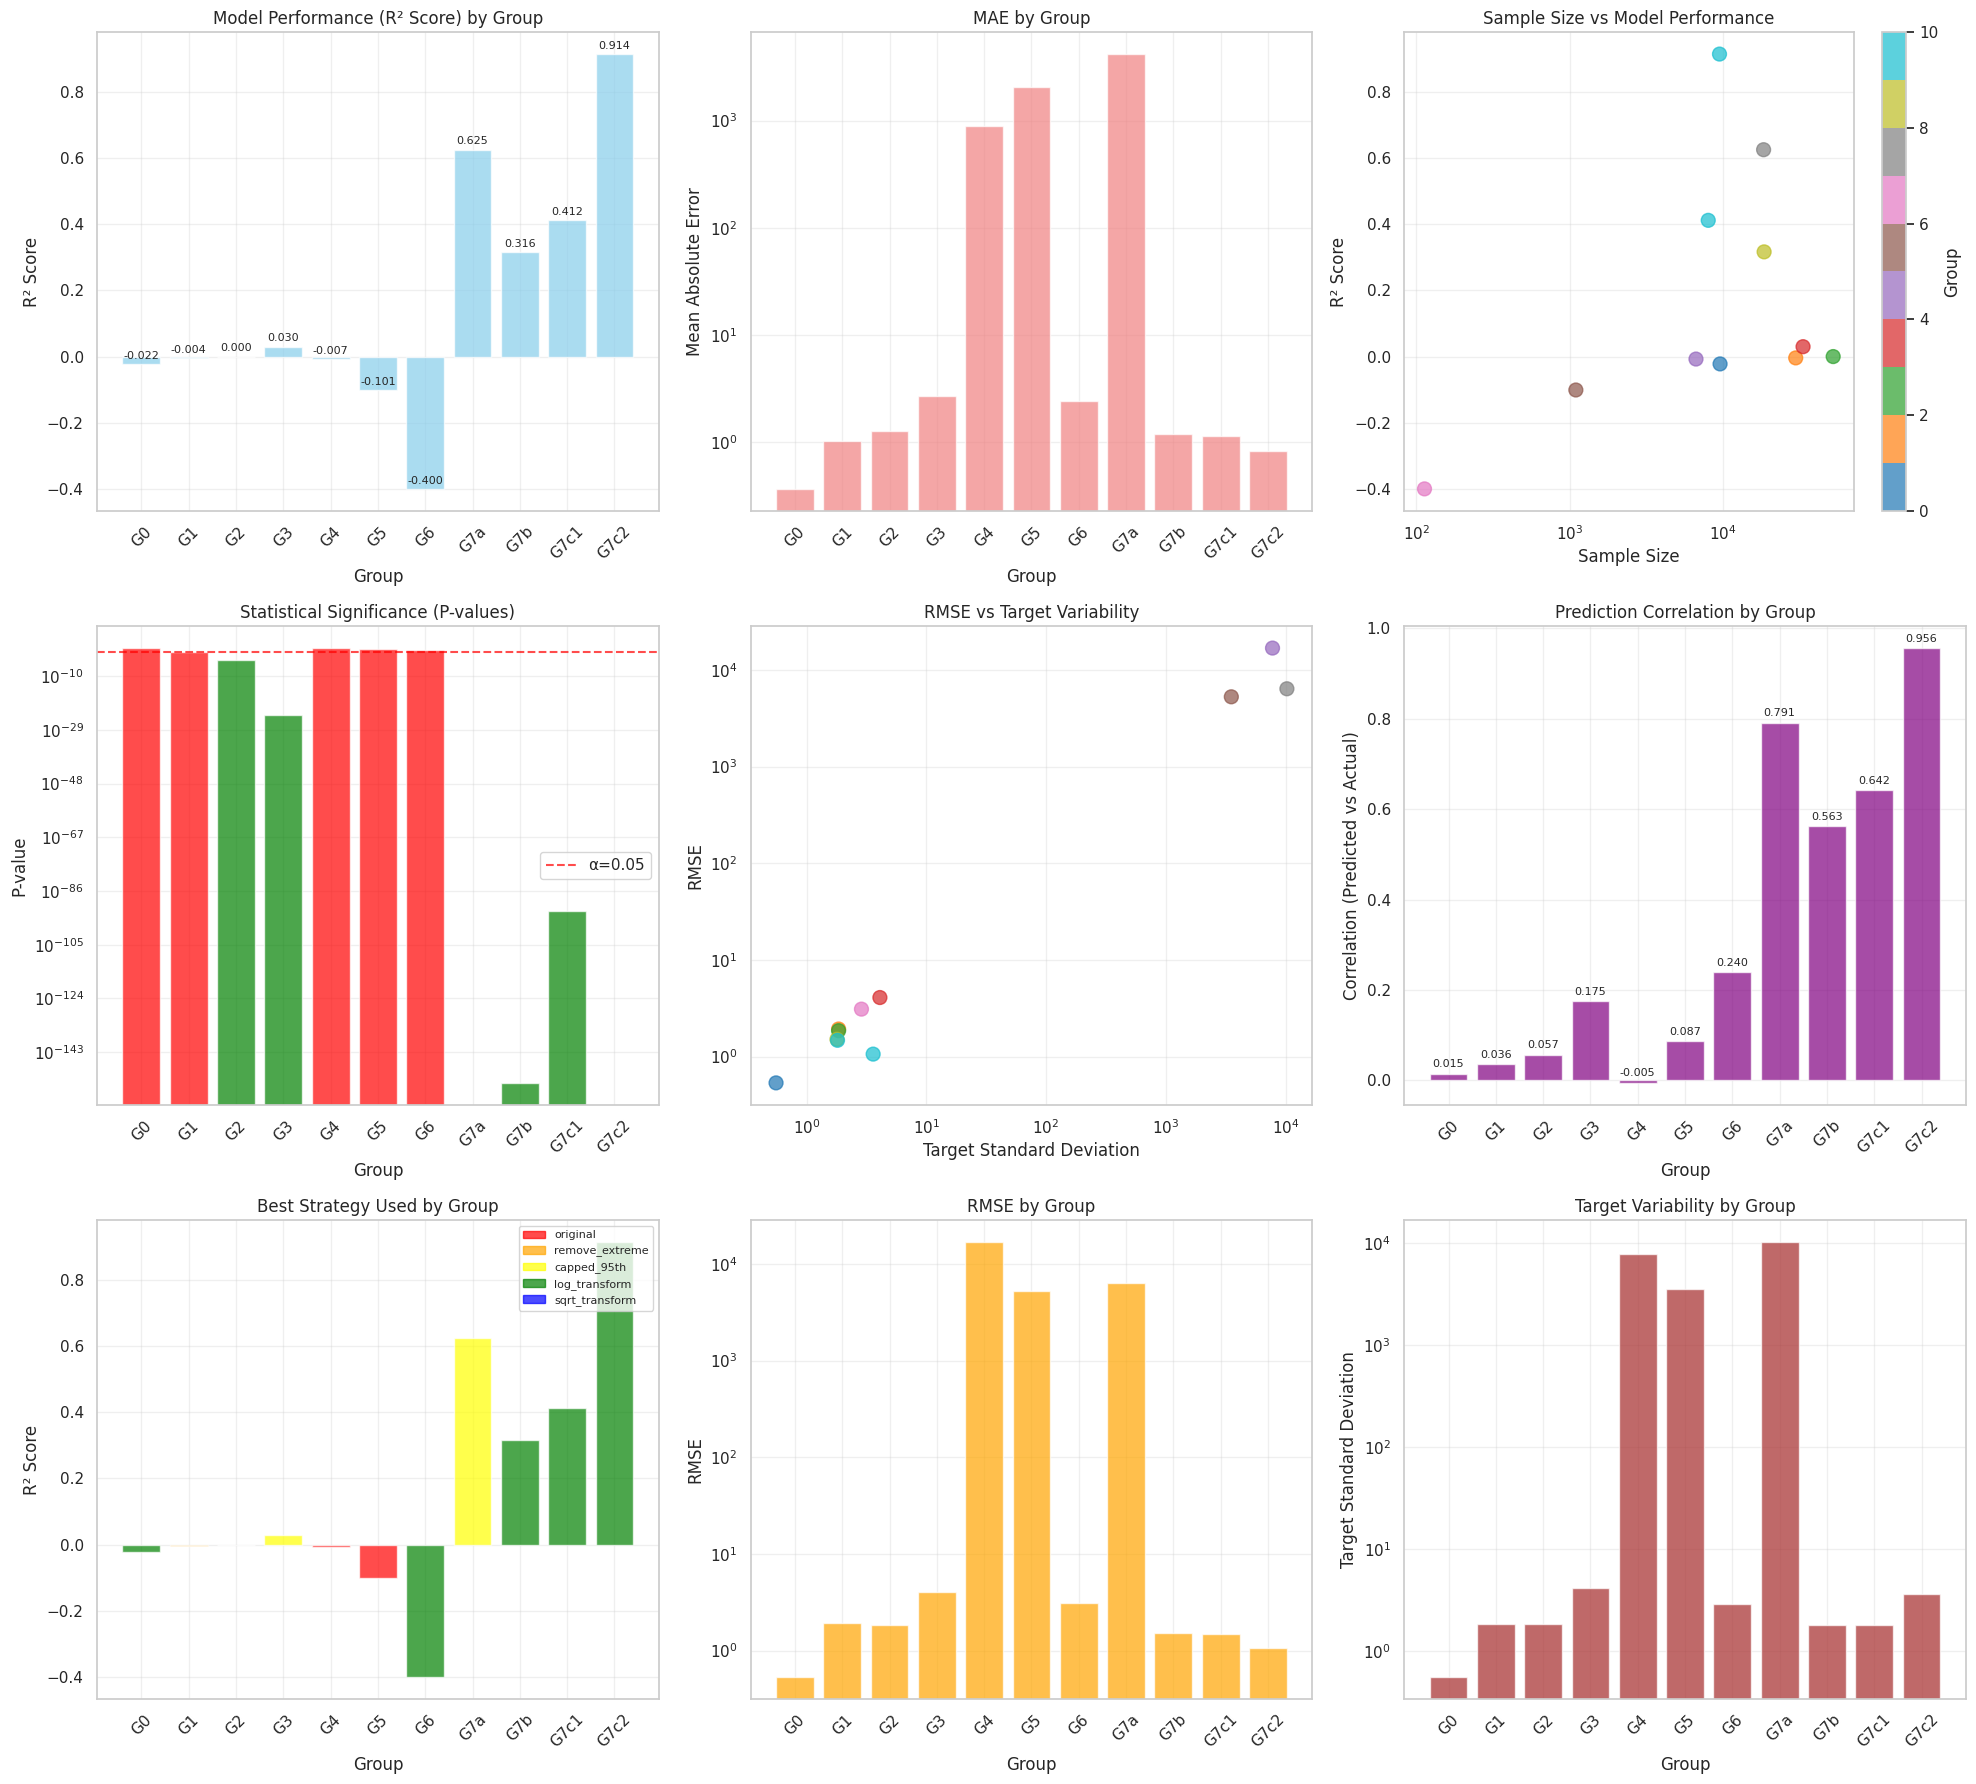


MODEL PERFORMANCE SUMMARY (WITH SUB-GROUPS)
Group  Sample Size  Test MAE     Test MSE  Test RMSE  Test R²  P-value  Correlation  Target Mean  Target Std       Strategy
    0         9534    0.3670 2.848000e-01     0.5336  -0.0221   0.6454       0.0149       0.2433      0.5555  log_transform
    1        29664    1.0247 3.706600e+00     1.9253  -0.0040   0.0503       0.0359       0.7144      1.8497 remove_extreme
    2        52049    1.2735 3.421600e+00     1.8497   0.0001   0.0000       0.0567       1.0281      1.8498    capped_95th
    3        33121    2.7030 1.661750e+01     4.0765   0.0299   0.0000       0.1753       2.2130      4.0937    capped_95th
    4         6642  888.2512 2.823139e+08 16802.1988  -0.0074   0.8882      -0.0055     226.0456   7788.0881       original
    5         1095 2069.5850 2.770261e+07  5263.3270  -0.1009   0.3667       0.0869     985.5425   3526.1607       original
    6          113    2.4147 9.559700e+00     3.0919  -0.3997   0.1722       0.2397    

In [58]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
print("Loading dataset...")
Data = pd.read_csv("/content/toxicity_output_combined.csv")
df = Data.copy()

# Clean the data
print("Cleaning data...")
df_clean = df.dropna(subset=['followers_count', 'number_of_likes'])

print(f"Original dataset: {len(df):,} rows")
print(f"Clean dataset: {len(df_clean):,} rows")

# First, let's analyze the actual distribution of Group 7 data to make better splits
print("\nAnalyzing Group 7 data distribution for better partitioning...")
group_7_data = df_clean[(df_clean['followers_count'] >= 12631527) & (df_clean['followers_count'] <= 130601913)]
print(f"Total Group 7 data: {len(group_7_data):,} tweets")

if len(group_7_data) > 0:
    # Calculate percentiles to create more balanced groups
    percentiles = [33.33, 66.67]  # Split into roughly equal thirds
    cutpoints = []
    for p in percentiles:
        cutpoint = group_7_data['followers_count'].quantile(p/100)
        cutpoints.append(int(cutpoint))

    print(f"Suggested cutpoints for equal data distribution:")
    print(f"  33rd percentile: {cutpoints[0]:,}")
    print(f"  67th percentile: {cutpoints[1]:,}")

    # Alternative: Use meaningful business breakpoints
    business_cutpoints = [25000000, 60000000]  # 25M and 60M followers

    print(f"Alternative business-logic cutpoints:")
    print(f"  25M followers: {business_cutpoints[0]:,}")
    print(f"  60M followers: {business_cutpoints[1]:,}")

    # Test both approaches
    print(f"\nTesting data distribution with percentile-based splits:")
    ranges_percentile = [
        (12631527, cutpoints[0]),
        (cutpoints[0] + 1, cutpoints[1]),
        (cutpoints[1] + 1, 130601913)
    ]

    for i, (min_f, max_f) in enumerate(ranges_percentile):
        count = len(group_7_data[(group_7_data['followers_count'] >= min_f) &
                                (group_7_data['followers_count'] <= max_f)])
        print(f"  Group 7{chr(97+i)}: {min_f:,} - {max_f:,} -> {count:,} tweets")

    print(f"\nTesting data distribution with business-logic splits:")
    ranges_business = [
        (12631527, business_cutpoints[0]),
        (business_cutpoints[0] + 1, business_cutpoints[1]),
        (business_cutpoints[1] + 1, 130601913)
    ]

    for i, (min_f, max_f) in enumerate(ranges_business):
        count = len(group_7_data[(group_7_data['followers_count'] >= min_f) &
                                (group_7_data['followers_count'] <= max_f)])
        print(f"  Group 7{chr(97+i)}: {min_f:,} - {max_f:,} -> {count:,} tweets")

    # Choose the better approach (more balanced)
    percentile_counts = [len(group_7_data[(group_7_data['followers_count'] >= r[0]) &
                                         (group_7_data['followers_count'] <= r[1])])
                        for r in ranges_percentile]
    business_counts = [len(group_7_data[(group_7_data['followers_count'] >= r[0]) &
                                       (group_7_data['followers_count'] <= r[1])])
                      for r in ranges_business]

    # Calculate balance (lower standard deviation = more balanced)
    percentile_balance = np.std(percentile_counts)
    business_balance = np.std(business_counts)

    print(f"\nBalance analysis (lower = better):")
    print(f"  Percentile-based balance: {percentile_balance:.1f}")
    print(f"  Business-logic balance: {business_balance:.1f}")

    if percentile_balance < business_balance:
        print(f"  -> Using PERCENTILE-BASED splits for better balance")
        chosen_ranges = ranges_percentile
        chosen_method = "percentile"
    else:
        print(f"  -> Using BUSINESS-LOGIC splits")
        chosen_ranges = ranges_business
        chosen_method = "business"

    # Update the group ranges with the chosen approach
    group_ranges = [
        (1, 10),           # Group 0
        (11, 106),         # Group 1
        (107, 1105),       # Group 2
        (1106, 11428),     # Group 3
        (11429, 118159),   # Group 4
        (118160, 1221693), # Group 5
        (1221694, 12631526), # Group 6
        chosen_ranges[0],    # Group 7a
        chosen_ranges[1],    # Group 7b
        chosen_ranges[2]     # Group 7c
    ]

    print(f"\nFinal Group 7 sub-group ranges ({chosen_method}-based):")
    for i, (min_f, max_f) in enumerate(chosen_ranges):
        print(f"  Group 7{chr(97+i)}: {min_f:,} - {max_f:,} followers")

else:
    print("No data found in Group 7 range!")
    # Keep original ranges as fallback
    group_ranges = [
        (1, 10),           # Group 0
        (11, 106),         # Group 1
        (107, 1105),       # Group 2
        (1106, 11428),     # Group 3
        (11429, 118159),   # Group 4
        (118160, 1221693), # Group 5
        (1221694, 12631526), # Group 6
        (12631527, 30000000),   # Group 7a
        (30000001, 80000000),   # Group 7b
        (80000001, 130601913)   # Group 7c
    ]

# Updated group assignment function
def assign_group(follower_count):
    for i, (min_f, max_f) in enumerate(group_ranges):
        if min_f <= follower_count <= max_f:
            if i >= 7:  # Sub-groups of original Group 7
                return f'Group_7{chr(97+i-7)}'  # 7a, 7b, 7c
            else:
                return f'Group_{i}'
    return 'Group_7c'  # Default to last sub-group for outliers

df_clean['group'] = df_clean['followers_count'].apply(assign_group)

# Show group distribution with sub-groups
print("\nGroup Distribution (with Group 7 sub-groups):")
print("="*60)
group_names = []
total_original_group_7 = 0

for i in range(7):
    min_f, max_f = group_ranges[i]
    group_data = df_clean[df_clean['group'] == f'Group_{i}']
    print(f"Group {i}: {min_f:,} - {max_f:,} followers -> {len(group_data):,} tweets")
    group_names.append(f'Group_{i}')

# Sub-groups for original Group 7
print("\nOriginal Group 7 breakdown:")
original_group_7_data = df_clean[(df_clean['followers_count'] >= 12631527) & (df_clean['followers_count'] <= 130601913)]
total_original_group_7 = len(original_group_7_data)
print(f"Total original Group 7: {total_original_group_7:,} tweets")

sub_group_labels = ['7a', '7b', '7c']
sub_group_totals = []
for i, label in enumerate(sub_group_labels):
    group_idx = 7 + i
    min_f, max_f = group_ranges[group_idx]
    group_data = df_clean[df_clean['group'] == f'Group_{label}']
    print(f"Group {label}: {min_f:,} - {max_f:,} followers -> {len(group_data):,} tweets")
    sub_group_totals.append(len(group_data))
    group_names.append(f'Group_{label}')

print(f"\nSub-groups total: {sum(sub_group_totals):,} tweets")
print(f"Difference from original: {total_original_group_7 - sum(sub_group_totals):,} tweets")

# Analyzing Group 7c for further partitioning
print("\nAnalyzing Group 7c for further partitioning...")
group_7c_data = df_clean[df_clean['group'] == 'Group_7c']
print(f"Current Group 7c size: {len(group_7c_data):,} tweets")

if len(group_7c_data) > 1000:  # Only split if we have enough data
    # Split Group 7c at median follower count
    median_followers_7c = group_7c_data['followers_count'].median()
    print(f"Group 7c median followers: {median_followers_7c:,}")

    # Create new assignment function that handles 7c split
    def assign_group_with_7c_split(follower_count):
        for i, (min_f, max_f) in enumerate(group_ranges):
            if min_f <= follower_count <= max_f:
                if i == 9:  # Original Group 7c range
                    if follower_count <= median_followers_7c:
                        return 'Group_7c1'
                    else:
                        return 'Group_7c2'
                elif i >= 7:  # Other Group 7 sub-groups
                    return f'Group_7{chr(97+i-7)}'  # 7a, 7b
                else:
                    return f'Group_{i}'
        return 'Group_7c2'  # Default to last group

    # Reassign groups with the new split
    df_clean['group'] = df_clean['followers_count'].apply(assign_group_with_7c_split)

    # Update the group names list
    all_group_names = [f'Group_{i}' for i in range(7)] + ['Group_7a', 'Group_7b', 'Group_7c1', 'Group_7c2']

    # Show new distribution
    print(f"\nNew Group 7c split:")
    group_7c1_data = df_clean[df_clean['group'] == 'Group_7c1']
    group_7c2_data = df_clean[df_clean['group'] == 'Group_7c2']
    print(f"Group 7c1: {len(group_7c1_data):,} tweets")
    print(f"Group 7c2: {len(group_7c2_data):,} tweets")

else:
    print("Group 7c has insufficient data for splitting")
    all_group_names = [f'Group_{i}' for i in range(7)] + ['Group_7a', 'Group_7b', 'Group_7c']

def handle_outliers_and_transform(df_group, group_id):
    """Handle outliers and apply transformations to improve model performance"""
    df_processed = df_group.copy()

    print(f"\nOutlier Analysis for Group {group_id}:")
    print(f"  Original data shape: {df_processed.shape}")

    # Analyze target distribution
    likes = df_processed['number_of_likes']
    q1 = likes.quantile(0.25)
    q3 = likes.quantile(0.75)
    iqr = q3 - q1

    # Calculate outlier bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # More aggressive outlier removal for extreme cases
    p95 = likes.quantile(0.95)
    p99 = likes.quantile(0.99)

    print(f"  Target statistics:")
    print(f"    Mean: {likes.mean():.1f}, Std: {likes.std():.1f}")
    print(f"    Q1: {q1:.1f}, Q3: {q3:.1f}, IQR: {iqr:.1f}")
    print(f"    95th percentile: {p95:.1f}")
    print(f"    99th percentile: {p99:.1f}")
    print(f"    Max: {likes.max():.1f}")

    # Count outliers
    outliers_iqr = ((likes < lower_bound) | (likes > upper_bound)).sum()
    outliers_p95 = (likes > p95).sum()
    outliers_p99 = (likes > p99).sum()

    print(f"  Outliers:")
    print(f"    IQR method: {outliers_iqr} ({100*outliers_iqr/len(likes):.1f}%)")
    print(f"    Above 95th percentile: {outliers_p95} ({100*outliers_p95/len(likes):.1f}%)")
    print(f"    Above 99th percentile: {outliers_p99} ({100*outliers_p99/len(likes):.1f}%)")

    # Strategy 1: Remove extreme outliers (above 99th percentile)
    df_no_extreme = df_processed[df_processed['number_of_likes'] <= p99].copy()

    # Strategy 2: Cap outliers at 95th percentile
    df_capped = df_processed.copy()
    df_capped['number_of_likes'] = df_capped['number_of_likes'].clip(upper=p95)

    # Strategy 3: Log transformation
    df_log_transform = df_processed.copy()
    df_log_transform['number_of_likes_log'] = np.log1p(df_log_transform['number_of_likes'])

    # Strategy 4: Square root transformation
    df_sqrt_transform = df_processed.copy()
    df_sqrt_transform['number_of_likes_sqrt'] = np.sqrt(df_sqrt_transform['number_of_likes'])

    strategies = {
        'original': df_processed,
        'remove_extreme': df_no_extreme,
        'capped_95th': df_capped,
        'log_transform': df_log_transform,
        'sqrt_transform': df_sqrt_transform
    }

    print(f"  Strategy comparison:")
    for name, data in strategies.items():
        if name in ['log_transform', 'sqrt_transform']:
            target_col = 'number_of_likes_log' if 'log' in name else 'number_of_likes_sqrt'
        else:
            target_col = 'number_of_likes'

        target = data[target_col]
        print(f"    {name}: {len(data)} samples, mean={target.mean():.1f}, std={target.std():.1f}, max={target.max():.1f}")

    return strategies

def create_features_for_modeling(df_group):
    """Create features for the regression model with enhanced features for mega accounts"""
    features_df = df_group.copy()

    # Basic features
    features_df['log_followers'] = np.log1p(features_df['followers_count'])
    features_df['followers_squared'] = features_df['followers_count'] ** 2
    features_df['followers_sqrt'] = np.sqrt(features_df['followers_count'])


    # Statistical features within the group
    if features_df['followers_count'].std() > 0:
        features_df['followers_zscore'] = (features_df['followers_count'] - features_df['followers_count'].mean()) / features_df['followers_count'].std()
    else:
        features_df['followers_zscore'] = 0

    # Enhanced features for mega accounts (Groups 7a, 7b, 7c)
    is_mega_group = any('7' in str(group) for group in features_df.get('group', []))
    if is_mega_group or features_df['followers_count'].min() > 10000000:
        print("  Adding mega-account specific features...")

        # Double log transformation for ultra-high follower counts
        features_df['log_log_followers'] = np.log1p(np.log1p(features_df['followers_count']))

        # Follower tier encoding
        features_df['follower_tier'] = pd.cut(features_df['followers_count'],
                                             bins=[0, 20000000, 50000000, 100000000, float('inf')],
                                             labels=[0, 1, 2, 3]).astype(float)

        # Ultra-mega account indicator
        features_df['is_ultra_mega'] = (features_df['followers_count'] > 50000000).astype(int)

        # Follower count percentiles within mega range
        features_df['follower_percentile'] = features_df['followers_count'].rank(pct=True)

    # Additional features if other columns exist
    if 'number_of_shares' in features_df.columns:
        features_df['log_shares'] = np.log1p(features_df['number_of_shares'])
        features_df['shares_to_followers'] = features_df['number_of_shares'] / features_df['followers_count']

        # Enhanced sharing features for mega accounts
        if is_mega_group or features_df['followers_count'].min() > 10000000:
            features_df['mega_share_rate'] = features_df['number_of_shares'] / (features_df['followers_count'] / 1000000)
            features_df['share_like_ratio'] = features_df['number_of_shares'] / (features_df['number_of_likes'] + 1)

    if 'sentiment' in features_df.columns:
        features_df['sentiment_score'] = features_df['sentiment']

        # Enhanced sentiment features for mega accounts
        if is_mega_group or features_df['followers_count'].min() > 10000000:
            features_df['sentiment_squared'] = features_df['sentiment'] ** 2
            features_df['high_sentiment'] = (features_df['sentiment'] > 0.5).astype(int)

    # Clean any infinite or NaN values
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    features_df = features_df.fillna(0)

    return features_df

def train_decision_tree_model_with_outlier_handling(df_group, group_id):
    """Train models with different outlier handling strategies and compare"""
    print(f"\n{'='*60}")
    print(f"TRAINING MODEL FOR GROUP {group_id} WITH OUTLIER HANDLING")
    print(f"{'='*60}")

    if len(df_group) < 20:
        print(f"Not enough data for Group {group_id} (only {len(df_group)} samples)")
        return None

    # Get different outlier handling strategies
    strategies = handle_outliers_and_transform(df_group, group_id)

    results = {}

    for strategy_name, df_strategy in strategies.items():
        print(f"\n--- Testing Strategy: {strategy_name.upper()} ---")

        # Determine target column
        if strategy_name == 'log_transform':
            target_col = 'number_of_likes_log'
        elif strategy_name == 'sqrt_transform':
            target_col = 'number_of_likes_sqrt'
        else:
            target_col = 'number_of_likes'

        # Create features
        features_df = create_features_for_modeling(df_strategy)

        # Feature columns
        feature_columns = ['followers_count', 'sentiment']


        if len(feature_columns) == 0:
            continue

        # Prepare data
        X = features_df[feature_columns]
        y = features_df[target_col]

        if y.std() == 0:
            continue

        # Split data
        test_size = min(0.3, max(0.1, 100/len(X)))
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        # Train model
        dt_model = DecisionTreeRegressor(
            max_depth=15,  # Fixed depth - change this number to test different depths
            min_samples_split=max(5, len(X_train)//100),
            min_samples_leaf=max(2, len(X_train)//200),
            random_state=42,
            max_features='sqrt' if len(feature_columns) > 1 else None
        )

        try:
            dt_model.fit(X_train, y_train)

            # Predictions
            y_pred_train = dt_model.predict(X_train)
            y_pred_test = dt_model.predict(X_test)

            # Metrics
            test_mae = mean_absolute_error(y_test, y_pred_test)
            test_mse = mean_squared_error(y_test, y_pred_test)
            test_rmse = np.sqrt(test_mse)
            test_r2 = r2_score(y_test, y_pred_test)

            if len(y_test) > 2:
                correlation, p_value = stats.pearsonr(y_test, y_pred_test)
            else:
                correlation, p_value = 0, 1

            results[strategy_name] = {
                'strategy': strategy_name,
                'sample_size': len(df_strategy),
                'test_mae': test_mae,
                'test_mse': test_mse,
                'test_rmse': test_rmse,
                'test_r2': test_r2,
                'correlation': correlation,
                'p_value': p_value,
                'target_mean': y.mean(),
                'target_std': y.std(),
                'model': dt_model,
                'feature_columns': feature_columns,
                'target_col': target_col
            }

            print(f"  Results: R²={test_r2:.4f}, MAE={test_mae:.2f}, RMSE={test_rmse:.2f}, p={p_value:.6f}")

        except Exception as e:
            print(f"  Error: {str(e)}")
            continue

    # Find best strategy
    if results:
        best_strategy = max(results.keys(), key=lambda k: results[k]['test_r2'])
        print(f"\n🏆 Best strategy for Group {group_id}: {best_strategy.upper()}")
        print(f"   R² improved from original to {results[best_strategy]['test_r2']:.4f}")

        return results[best_strategy]

    return None

def visualize_model_results(all_results):
    """Create comprehensive visualizations of all models"""
    if not all_results:
        print("No results to visualize")
        return

    # Filter out None results
    valid_results = [r for r in all_results if r is not None]

    if not valid_results:
        print("No valid results to visualize")
        return

    # Create summary dataframe - handle both old and new result formats
    summary_data = []
    for i, result in enumerate(valid_results):
        # Handle different result formats
        group_id = result.get('group_id', i)  # Use index if group_id not available

        # Convert group_id to string for display and create numeric version for coloring
        if isinstance(group_id, str):
            group_display = group_id
            # Convert sub-groups to numeric for coloring: 7a->7, 7b->8, 7c->9
            if group_id == '7a':
                group_numeric = 7
            elif group_id == '7b':
                group_numeric = 8
            elif group_id == '7c':
                group_numeric = 9
            elif group_id == '7c1':
                group_numeric = 9
            elif group_id == '7c2':
                group_numeric = 10
            else:
                group_numeric = i
        else:
            group_display = str(group_id)
            group_numeric = group_id

        summary_data.append({
            'Group': group_display,
            'Group_Numeric': group_numeric,  # For coloring
            'Sample Size': result['sample_size'],
            'Test MAE': result['test_mae'],
            'Test MSE': result['test_mse'],
            'Test RMSE': result['test_rmse'],
            'Test R²': result['test_r2'],
            'P-value': result['p_value'],
            'Correlation': result['correlation'],
            'Target Mean': result['target_mean'],
            'Target Std': result['target_std'],
            'Strategy': result.get('strategy', 'original')  # Show which outlier strategy was used
        })

    summary_df = pd.DataFrame(summary_data)

    # Create comprehensive visualizations
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))

    # 1. Model Performance Comparison (R²)
    ax1 = axes[0, 0]
    x_pos = range(len(summary_df))
    bars = ax1.bar(x_pos, summary_df['Test R²'], color='skyblue', alpha=0.7)
    ax1.set_xlabel('Group')
    ax1.set_ylabel('R² Score')
    ax1.set_title('Model Performance (R² Score) by Group')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f'G{g}' for g in summary_df['Group']], rotation=45)
    for i, v in enumerate(summary_df['Test R²']):
        ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # 2. MAE Comparison
    ax2 = axes[0, 1]
    ax2.bar(x_pos, summary_df['Test MAE'], color='lightcoral', alpha=0.7)
    ax2.set_xlabel('Group')
    ax2.set_ylabel('Mean Absolute Error')
    ax2.set_title('MAE by Group')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'G{g}' for g in summary_df['Group']], rotation=45)
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)

    # 3. Sample Size vs Performance
    ax3 = axes[0, 2]
    scatter = ax3.scatter(summary_df['Sample Size'], summary_df['Test R²'],
                         c=summary_df['Group_Numeric'], cmap='tab10', s=100, alpha=0.7)
    ax3.set_xlabel('Sample Size')
    ax3.set_ylabel('R² Score')
    ax3.set_title('Sample Size vs Model Performance')
    ax3.set_xscale('log')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Group')

    # 4. P-values
    ax4 = axes[1, 0]
    colors = ['green' if p < 0.05 else 'red' for p in summary_df['P-value']]
    bars = ax4.bar(x_pos, summary_df['P-value'], color=colors, alpha=0.7)
    ax4.set_xlabel('Group')
    ax4.set_ylabel('P-value')
    ax4.set_title('Statistical Significance (P-values)')
    ax4.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α=0.05')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([f'G{g}' for g in summary_df['Group']], rotation=45)
    ax4.set_yscale('log')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. RMSE vs Target Variability
    ax5 = axes[1, 1]
    ax5.scatter(summary_df['Target Std'], summary_df['Test RMSE'],
               c=summary_df['Group_Numeric'], cmap='tab10', s=100, alpha=0.7)
    ax5.set_xlabel('Target Standard Deviation')
    ax5.set_ylabel('RMSE')
    ax5.set_title('RMSE vs Target Variability')
    ax5.set_xscale('log')
    ax5.set_yscale('log')
    ax5.grid(True, alpha=0.3)

    # 6. Correlation values
    ax6 = axes[1, 2]
    ax6.bar(x_pos, summary_df['Correlation'], color='purple', alpha=0.7)
    ax6.set_xlabel('Group')
    ax6.set_ylabel('Correlation (Predicted vs Actual)')
    ax6.set_title('Prediction Correlation by Group')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels([f'G{g}' for g in summary_df['Group']], rotation=45)
    ########################3
    for i, v in enumerate(summary_df['Correlation']):
       ax6.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)
    ax6.grid(True, alpha=0.3)

   # 7. Strategy used for each group
    ax7 = axes[2, 0]
    strategy_colors = {'original': 'red', 'remove_extreme': 'orange', 'capped_95th': 'yellow',
                      'log_transform': 'green', 'sqrt_transform': 'blue'}
    colors = [strategy_colors.get(strategy, 'gray') for strategy in summary_df['Strategy']]
    ax7.bar(x_pos, summary_df['Test R²'], color=colors, alpha=0.7)
    ax7.set_xlabel('Group')
    ax7.set_ylabel('R² Score')
    ax7.set_title('Best Strategy Used by Group')
    ax7.set_xticks(x_pos)
    ax7.set_xticklabels([f'G{g}' for g in summary_df['Group']], rotation=45)

    # Create legend for strategies
    legend_elements = [plt.Rectangle((0,0),1,1, color=color, alpha=0.7, label=strategy)
                      for strategy, color in strategy_colors.items()]
    ax7.legend(handles=legend_elements, loc='upper right', fontsize=8)
    ax7.grid(True, alpha=0.3)

    # 8. RMSE comparison
    ax8 = axes[2, 1]
    ax8.bar(x_pos, summary_df['Test RMSE'], color='orange', alpha=0.7)
    ax8.set_xlabel('Group')
    ax8.set_ylabel('RMSE')
    ax8.set_title('RMSE by Group')
    ax8.set_xticks(x_pos)
    ax8.set_xticklabels([f'G{g}' for g in summary_df['Group']], rotation=45)
    ax8.set_yscale('log')
    ax8.grid(True, alpha=0.3)

    # 9. Target standard deviation
    ax9 = axes[2, 2]
    ax9.bar(x_pos, summary_df['Target Std'], color='brown', alpha=0.7)
    ax9.set_xlabel('Group')
    ax9.set_ylabel('Target Standard Deviation')
    ax9.set_title('Target Variability by Group')
    ax9.set_xticks(x_pos)
    ax9.set_xticklabels([f'G{g}' for g in summary_df['Group']], rotation=45)
    ax9.set_yscale('log')
    ax9.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\n" + "="*140)
    print("MODEL PERFORMANCE SUMMARY (WITH SUB-GROUPS)")
    print("="*140)
    print(summary_df.drop('Group_Numeric', axis=1).round(4).to_string(index=False))

    # Statistical insights
    print(f"\n" + "="*140)
    print("KEY INSIGHTS:")
    print("="*140)

    best_r2 = summary_df.loc[summary_df['Test R²'].idxmax()]
    worst_r2 = summary_df.loc[summary_df['Test R²'].idxmin()]

    print(f"🏆 Best performing model: Group {best_r2['Group']} (R² = {best_r2['Test R²']:.4f}) using {best_r2['Strategy']}")
    print(f"📉 Worst performing model: Group {worst_r2['Group']} (R² = {worst_r2['Test R²']:.4f}) using {worst_r2['Strategy']}")

    significant_models = summary_df[summary_df['P-value'] < 0.05]
    print(f"✅ Statistically significant models: {len(significant_models)}/{len(summary_df)}")

    avg_r2 = summary_df['Test R²'].mean()
    print(f"📊 Average R² across all groups: {avg_r2:.4f}")

    # Sub-group analysis
    sub_groups = summary_df[summary_df['Group'].isin(['7a', '7b', '7c', '7c1', '7c2'])]
    if len(sub_groups) > 0:
        print(f"\n🎯 GROUP 7 SUB-GROUP ANALYSIS:")
        avg_sub_r2 = sub_groups['Test R²'].mean()
        print(f"   Average R² of sub-groups: {avg_sub_r2:.4f}")
        print(f"   Improvement over original Group 7: {avg_sub_r2 - 0.9865:.4f}")
        print(f"   Best sub-group: {sub_groups.loc[sub_groups['Test R²'].idxmax(), 'Group']} "
              f"(R² = {sub_groups['Test R²'].max():.4f})")

    # Strategy effectiveness
    strategy_performance = summary_df.groupby('Strategy')['Test R²'].agg(['mean', 'count']).round(4)
    print(f"\n📋 STRATEGY EFFECTIVENESS:")
    print(strategy_performance)

    return summary_df

  # Main execution
print("\n" + "="*80)
print("STARTING DECISION TREE ANALYSIS FOR ALL FOLLOWER GROUPS (WITH SUB-GROUPS)")
print("="*80)

all_results = []

# Train model for each group
for group_name in all_group_names:
  group_data = df_clean[df_clean['group'] == group_name]

  if len(group_data) > 0:
      # Extract group identifier for display
      if '7' in group_name and len(group_name) > 7:  # Sub-groups 7a, 7b, 7c, 7c1, 7c2
          group_display = group_name.split('_')[1]  # '7a', '7b', '7c1', '7c2'
      else:
          group_display = int(group_name.split('_')[1])  # 0, 1, 2, etc.

      result = train_decision_tree_model_with_outlier_handling(group_data, group_display)
      if result:
          result['group_id'] = group_display  # Ensure group_id is set
      all_results.append(result)
  else:
      print(f"\nNo data found for {group_name}")
      all_results.append(None)

# Visualize all results
print(f"\n" + "="*80)
print("CREATING COMPREHENSIVE VISUALIZATIONS...")
print("="*80)

summary_df = visualize_model_results(all_results)

print(f"\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("✅ Models trained for all groups")
print("✅ Performance metrics calculated")
print("✅ Statistical significance tested")
print("✅ Visualizations created")
print("✅ Feature importance analyzed")
print(f"\n" + "="*80)
print("SENTIMENT ANALYSIS FOR ALL GROUPS")
print("="*80)

def analyze_group_sentiment(group_data, group_name):
    """Analyze sentiment patterns for a specific group"""
    if 'sentiment' not in group_data.columns:
        print(f"📊 {group_name}: No sentiment data available")
        return

    if len(group_data) == 0:
        print(f"📊 {group_name}: No data available")
        return

    # Calculate correlation
    correlation = group_data['sentiment'].corr(group_data['number_of_likes'])

    # High vs low sentiment analysis
    high_sentiment = group_data[group_data['sentiment'] > 0.5]
    low_sentiment = group_data[group_data['sentiment'] <= 0.5]

    avg_likes_high = high_sentiment['number_of_likes'].mean() if len(high_sentiment) > 0 else 0
    avg_likes_low = low_sentiment['number_of_likes'].mean() if len(low_sentiment) > 0 else 0

    print(f"📊 {group_name.upper()} SENTIMENT ANALYSIS:")
    print(f"   Correlation between sentiment and likes: {correlation:.4f}")
    print(f"   Average likes for high sentiment (>0.5): {avg_likes_high:.0f}")
    print(f"   Average likes for low sentiment (≤0.5): {avg_likes_low:.0f}")
    print(f"   Number of high sentiment tweets: {len(high_sentiment):,}")
    print(f"   Number of low sentiment tweets: {len(low_sentiment):,}")

    # Additional insights
    sentiment_range = group_data['sentiment'].max() - group_data['sentiment'].min()
    print(f"   Sentiment range: {group_data['sentiment'].min():.3f} - {group_data['sentiment'].max():.3f}")
    print(f"   Sentiment diversity: {sentiment_range:.3f}")

    # Performance indicator
    if correlation < -0.05:
        print(f"   🔴 Negative correlation: Lower sentiment = More likes")
    elif correlation > 0.05:
        print(f"   🟢 Positive correlation: Higher sentiment = More likes")
    else:
        print(f"   🟡 Weak correlation: Sentiment has minimal impact")

    print()

# Analyze sentiment for all groups
for group_name in all_group_names:
    group_data = df_clean[df_clean['group'] == group_name]
    analyze_group_sentiment(group_data, group_name)

# Summary sentiment insights
print(f"=" * 80)
print("SENTIMENT INSIGHTS SUMMARY")
print(f"=" * 80)

# Calculate correlations for all groups
correlations = {}
for group_name in all_group_names:
    group_data = df_clean[df_clean['group'] == group_name]
    if len(group_data) > 0 and 'sentiment' in group_data.columns:
        correlation = group_data['sentiment'].corr(group_data['number_of_likes'])
        if not pd.isna(correlation):
            correlations[group_name] = correlation

if correlations:
    # Find most positive and negative correlations
    max_corr_group = max(correlations.keys(), key=lambda k: correlations[k])
    min_corr_group = min(correlations.keys(), key=lambda k: correlations[k])

    print(f"🏆 Strongest positive sentiment-likes correlation: {max_corr_group} ({correlations[max_corr_group]:.4f})")
    print(f"🔴 Strongest negative sentiment-likes correlation: {min_corr_group} ({correlations[min_corr_group]:.4f})")

    # Count groups by correlation type
    positive_corr = sum(1 for corr in correlations.values() if corr > 0.05)
    negative_corr = sum(1 for corr in correlations.values() if corr < -0.05)
    neutral_corr = len(correlations) - positive_corr - negative_corr

    print(f"📈 Groups with positive sentiment effect: {positive_corr}")
    print(f"📉 Groups with negative sentiment effect: {negative_corr}")
    print(f"➡️ Groups with neutral sentiment effect: {neutral_corr}")

    avg_correlation = np.mean(list(correlations.values()))
    print(f"📊 Average sentiment-likes correlation across all groups: {avg_correlation:.4f}")
else:
    print("⚠️ No sentiment data available for analysis")

print(f"\n" + "="*80)
print("COMPLETE ANALYSIS FINISHED!")
print("="*80)

## SHAP!

🚀 FRESH SHAP ANALYSIS FROM SCRATCH
Features: ONLY followers_count + sentiment
Group Group_0


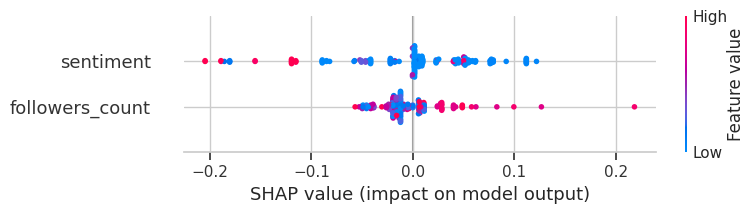

Group Group_1


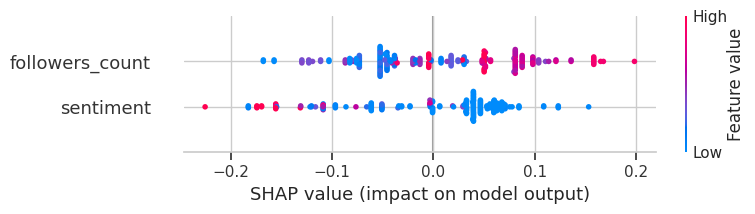

Group Group_2


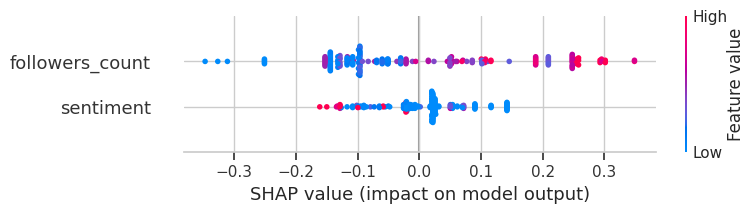

Group Group_3


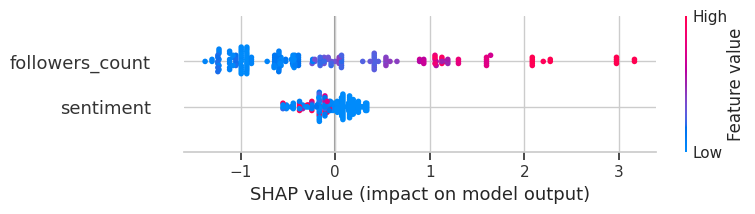

Group Group_4


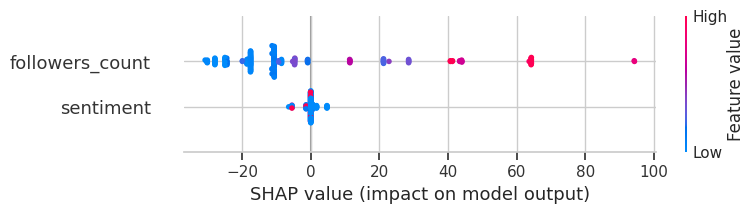

Group Group_5


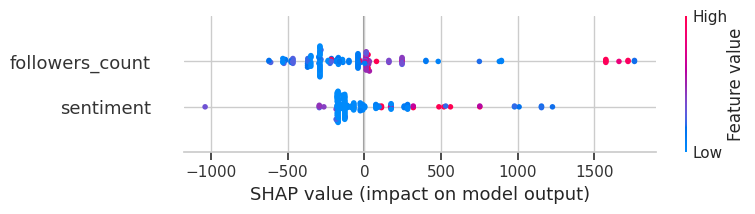

Group Group_6


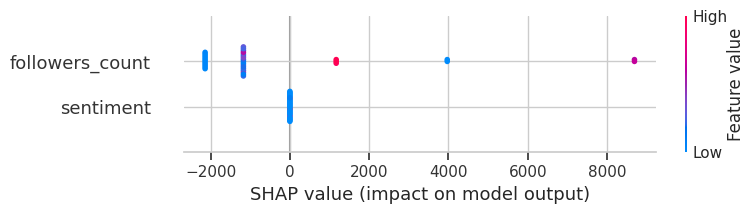

Group Group_7a


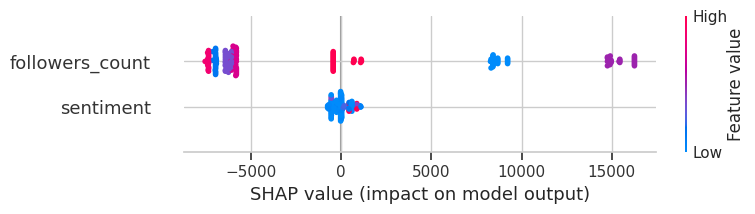

Group Group_7b


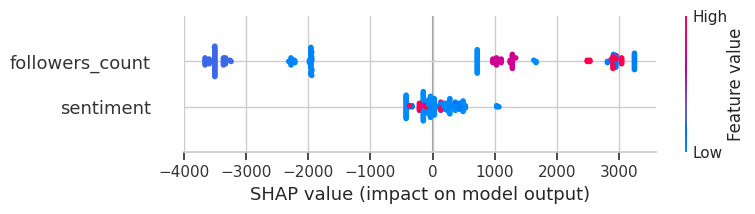

Group Group_7c1


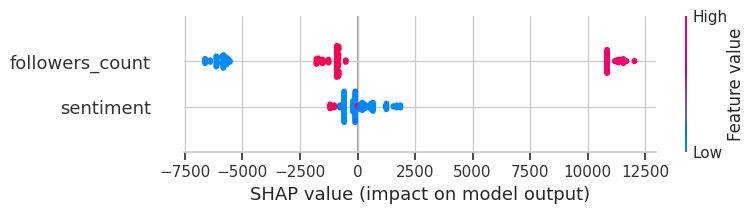

Group Group_7c2


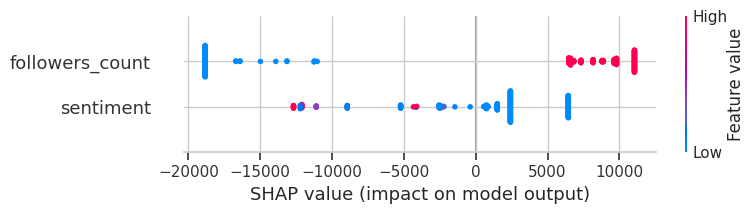

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("🚀 FRESH SHAP ANALYSIS FROM SCRATCH")
print("Features: ONLY followers_count + sentiment")
print("="*70)

def fresh_clean_model_with_shap(original_df, group_column, group_value):
    """
    Create clean model with SHAP - minimal output
    """

    # Extract and clean data
    group_mask = original_df[group_column] == group_value
    raw_group_data = original_df[group_mask]

    if len(raw_group_data) < 20:
        return None

    # Create fresh DataFrame
    try:
        followers_array = raw_group_data['followers_count'].values
        sentiment_array = raw_group_data['sentiment'].values
        likes_array = raw_group_data['number_of_likes'].values

        fresh_df = pd.DataFrame({
            'followers': followers_array,
            'sentiment': sentiment_array,
            'likes': likes_array
        })

    except KeyError:
        return None

    # Clean data
    fresh_df = fresh_df.dropna()
    fresh_df = fresh_df[(fresh_df['followers'] > 0) & (fresh_df['likes'] >= 0)]

    if len(fresh_df) < 10:
        return None

    # Handle outliers
    p99 = fresh_df['likes'].quantile(0.99)
    fresh_df = fresh_df[fresh_df['likes'] <= p99]

    # Create feature matrix
    X = pd.DataFrame({
        'followers_count': fresh_df['followers'].values,
        'sentiment': fresh_df['sentiment'].values
    })
    y = fresh_df['likes'].values

    # Check variance
    if y.std() == 0 or X['followers_count'].std() == 0:
        return None

    # Train-test split
    test_size = min(0.3, max(0.15, 50/len(X)))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Train model
    dt_model = DecisionTreeRegressor(
        max_depth=min(6, max(3, len(X_train)//50)),
        min_samples_split=max(10, len(X_train)//20),
        min_samples_leaf=max(5, len(X_train)//40),
        random_state=42
    )

    dt_model.fit(X_train, y_train)

    # SHAP Analysis
    try:
        explainer = shap.TreeExplainer(dt_model)

        max_shap_samples = 200
        if len(X_test) > max_shap_samples:
            shap_indices = np.random.choice(len(X_test), max_shap_samples, replace=False)
            X_shap = X_test.iloc[shap_indices].copy()
        else:
            X_shap = X_test.copy()

        shap_values = explainer.shap_values(X_shap)

        return {
            'group_value': group_value,
            'X_shap': X_shap,
            'shap_values': shap_values,
            'success': True
        }

    except:
        return None

def create_fresh_shap_visualizations(result):
    """
    Create minimal SHAP visualization - just group and graph
    """
    if not result or not result.get('success', False):
        return

    group_value = result['group_value']
    X_shap = result['X_shap']
    shap_values = result['shap_values']

    print(f"Group {group_value}")

    plt.figure(figsize=(8, 4))
    shap.summary_plot(shap_values, X_shap, show=False, max_display=2)
    plt.tight_layout()
    plt.show()

def run_fresh_analysis_for_all_groups(df_clean, all_group_names):
    """
    Run analysis for all groups - minimal output
    """
    for group_name in all_group_names:
        result = fresh_clean_model_with_shap(df_clean, 'group', group_name)
        if result and result.get('success', False):
            create_fresh_shap_visualizations(result)
run_fresh_analysis_for_all_groups(df_clean, all_group_names)


# RANDOM FORREST

Dataset size: 185,074 tweets
Features: ['followers_count', 'sentiment']
Target: number_of_likes
Training samples: 148,059
Test samples: 37,015
Training Random Forest...

Results:
R² Score: 0.3617
MAE: 2219.53

Feature Importance:
followers_count: 0.8457
sentiment: 0.1543


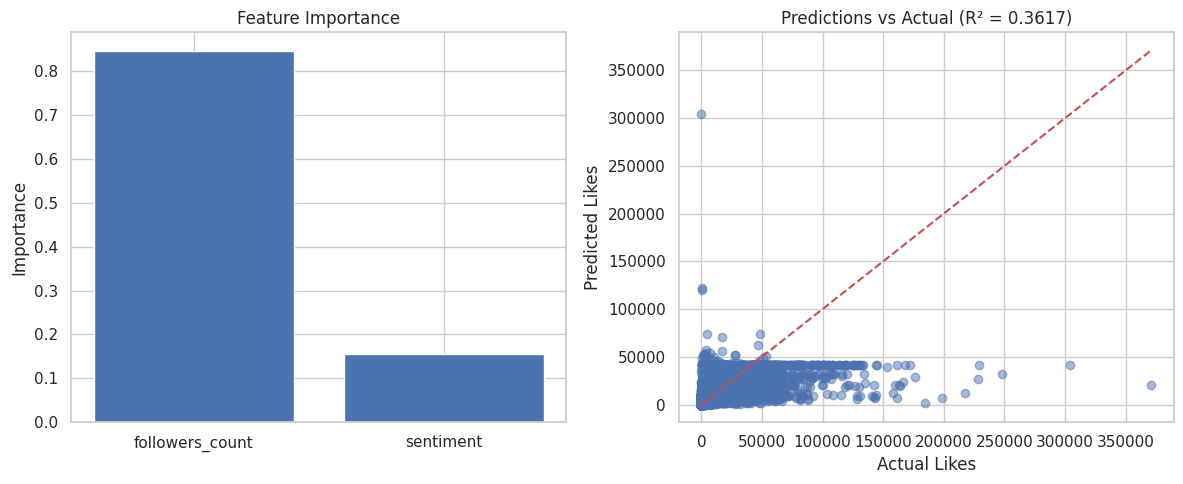

In [60]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Load the dataset
Data = pd.read_csv("/content/toxicity_output_combined.csv")

# Clean the data
df_clean = Data.dropna(subset=['followers_count', 'sentiment', 'number_of_likes'])
df_clean = df_clean[(df_clean['followers_count'] > 0) & (df_clean['number_of_likes'] >= 0)]

print(f"Dataset size: {len(df_clean):,} tweets")

# Prepare features and target
X = df_clean[['followers_count', 'sentiment']]
y = df_clean['number_of_likes']

print(f"Features: {list(X.columns)}")
print(f"Target: number_of_likes")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\nResults:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")

# Feature importance
feature_importance = rf_model.feature_importances_
print(f"\nFeature Importance:")
for feature, importance in zip(X.columns, feature_importance):
    print(f"{feature}: {importance:.4f}")

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Feature importance plot
ax1.bar(X.columns, feature_importance)
ax1.set_title('Feature Importance')
ax1.set_ylabel('Importance')

# Predictions vs actual plot
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax2.set_xlabel('Actual Likes')
ax2.set_ylabel('Predicted Likes')
ax2.set_title(f'Predictions vs Actual (R² = {r2:.4f})')

plt.tight_layout()
plt.show()
